# Overview

In this competition, we benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. We also have the opportunity to create new features to improve your results.

See the [README](README.md) for further details

## Approach

In this notebook, we leverage a custom API, [JLpyUtils](https://pypi.org/project/JLpyUtils/), the author ([John Leonard](https://www.linkedin.com/in/johntleonard/)) has developed to streamline exploritory data analysis, feature engineering, and model selection tasks. Furthermore, we heavily utilize the [dask](https://dask.org), as it is much more efficient at managing large datasets such as those used in this analysis. To further improve our memory resource management, we often use python manual garbage collection function ```gc.collect()``` to clear out deleted objects from memory.

# Install Libs

In [1]:
!pip install JLpyUtils==0.2.9
!pip install tensorflow==1.14.0
!pip install tensorflow-gpu==1.14.0
!pip install dask_ml

import IPython.display
IPython.display.clear_output()

# Import Libs

In [50]:
import numpy as np
import pandas as pd
import sys, os, importlib, gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

import dask
import dask_xgboost
import dask_ml, dask_ml.model_selection

In [3]:
pd.options.display.max_columns = 1000
mpl.rcParams['font.size']=14

In [4]:
dev = True

In [5]:
path_desktop = '/mr3_boltprod_john_t_leonard/Data_Science_Projects.'
if dev:
    print('Running in dev mode. Using local copy of JLpyUtils')
    path_dev_repo = os.path.join(path_desktop,'JLpyUtils')
    sys.path.insert(0, path_dev_repo)

import JLpyUtils

Running in dev mode. Using local copy of JLpyUtils


In [6]:
JLpyUtils.__version__

'0.2.9'

# Download Raw Data

This competion uses train test sets that are >100 mb, which is githubs standard limit, thus we don't store the dataset directly in the repo.. Below, we download the data from kaggle URL specified at the competition home page

In [7]:
path_raw_data_dir = 'ieee-fraud-detection'

In [8]:
# from kaggle.api.kaggle_api_extended import KaggleApi

# api = KaggleApi()
# api.authenticate()

# files = api.competition_download_files("ieee-fraud-detection", path = path_raw_data_dir)

# import zipfile
# for file in os.listdir(path_raw_data_dir):
#     if 'zip' in file:
#         with zipfile.ZipFile(os.path.join(path_raw_data_dir, file) , 'r') as zip_ref:
#             zip_ref.extractall(path_raw_data_dir)
#         os.remove(os.path.join(path_raw_data_dir, file))

# Load Data

In [9]:
def load_df(path_raw_data_dir,
            train_test_id = 'train'):
    """
    Load the train or test df by left joining the transaction data with the identity data on the 'TransactionID' header
    """
    import gc 
    
    import dask.dataframe as dd
    
    df_transaction = dd.read_csv(os.path.join( path_raw_data_dir, train_test_id+'_transaction.csv'))
    df_identity = dd.read_csv(os.path.join( path_raw_data_dir, train_test_id+'_identity.csv'))
    
    df = dd.merge(df_transaction, df_identity, how='left', on = 'TransactionID')



    
    del df_transaction, df_identity
    gc.collect()
    return df

df = load_df(path_raw_data_dir, train_test_id = 'train')
display(df.info())
display(df.head(), df.shape)

<class 'dask.dataframe.core.DataFrame'>
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: object(31), float64(399), int64(4)

None

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

(Delayed('int-6bfd6166-6643-4224-aa1f-0bbf838e47cc'), 434)

# Define Feature and Label headers

In [10]:
def fetch_headers_dict():
    headers_dict = {'labels':['isFraud'],
                    'UID':'TransactionID'}
    headers_dict['features'] = list(df.drop(columns=headers_dict['labels']+ [headers_dict['UID']]).columns)
    headers_dict['categorical features'] = ['ProductCD']+[header for header in headers_dict['features'] if 'card' in header or 'addr' in header or 'emaildomain' in header or 'M' in header or 'Device' in header and header != headers_dict['UID']] + ['id_'+str(int_) for int_ in range(12,39)]
    headers_dict['continuous features'] = [feature for feature in headers_dict['features'] if feature not in headers_dict['categorical features']]
    return headers_dict

headers_dict = fetch_headers_dict()
for key in headers_dict.keys():
    print('\n',key,':', headers_dict[key])


 labels : ['isFraud']

 UID : TransactionID

 features : ['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 

# Define X and Y

In [11]:
X = df[headers_dict['features']]
y = df[headers_dict['labels']]

# Basic Feature Cleaning

In [12]:
def basic_feat_cleaner(X):
    import warnings
    warnings.filterwarnings('ignore')
    
    X['M1'] = X['M1'].fillna('F')
    
    warnings.filterwarnings('default')
    return X

X = basic_feat_cleaner(X)

# Plot Subset of Data

In [13]:
X = X.head(1000)
y = y.head(1000)

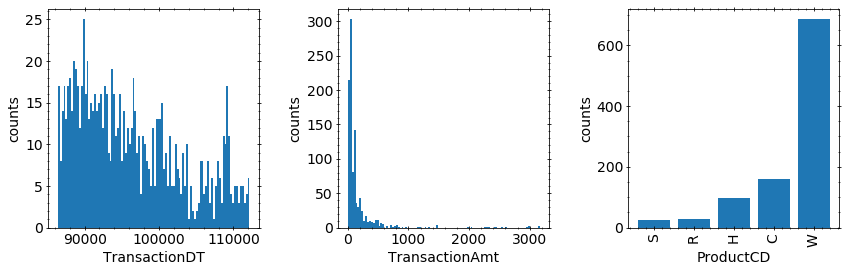

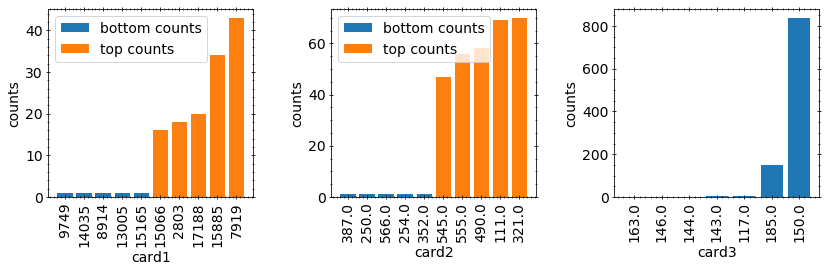

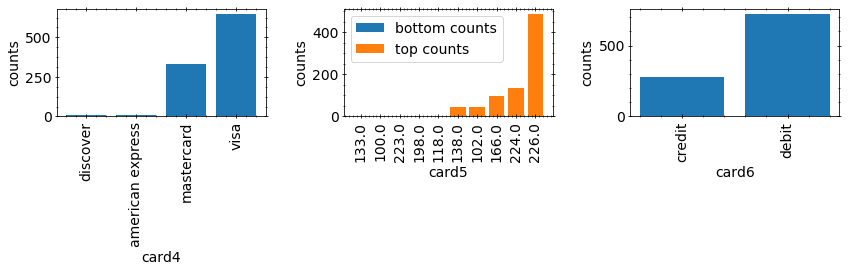

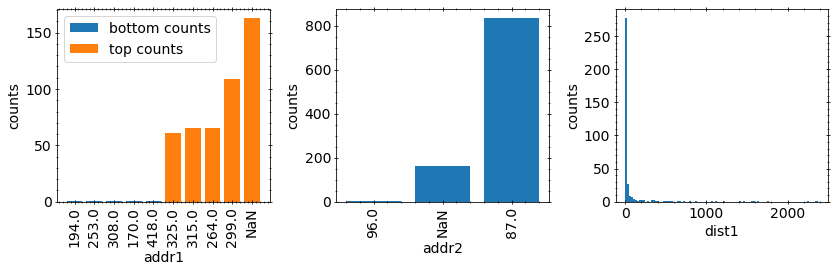

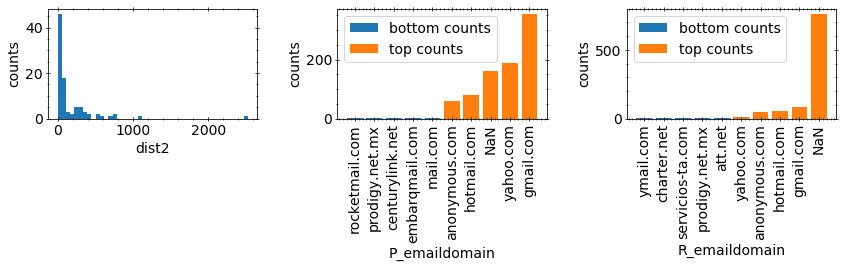

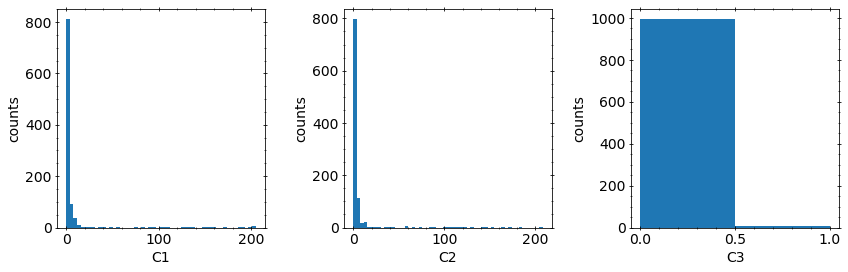

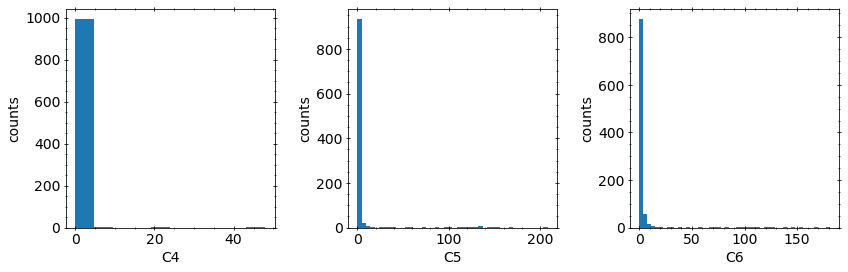

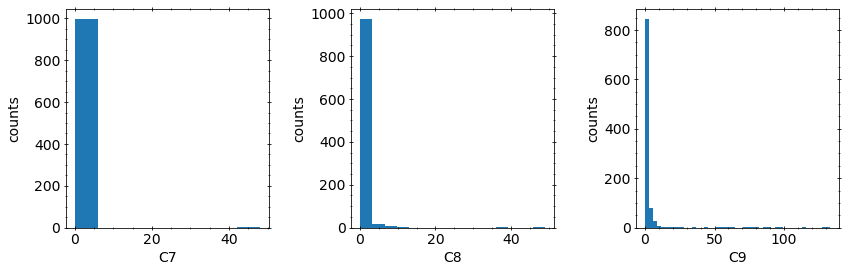

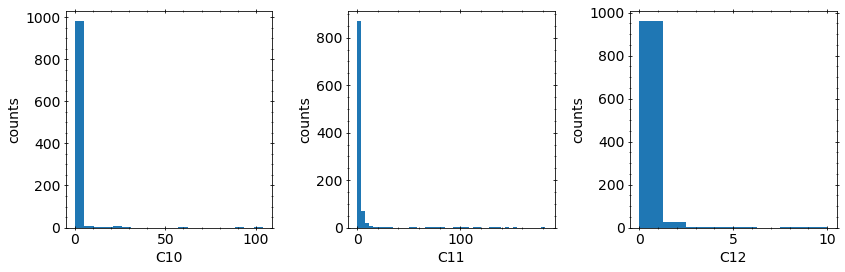

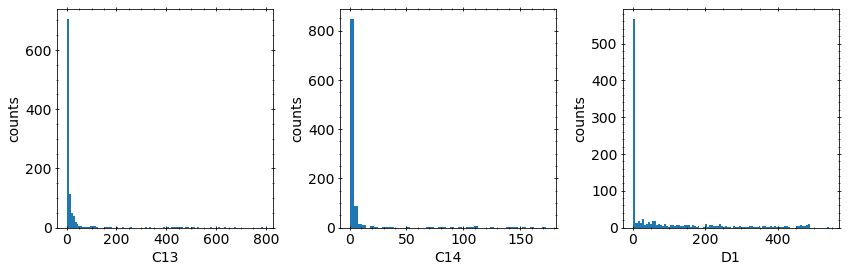

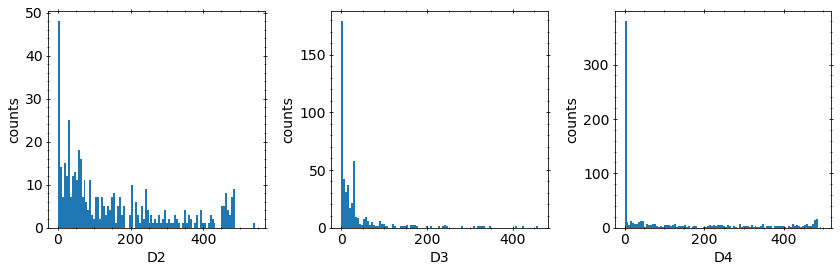

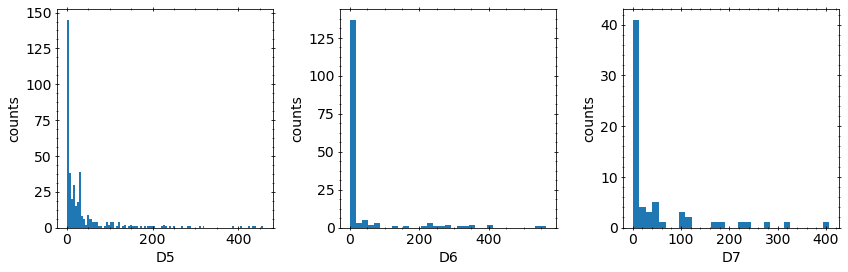

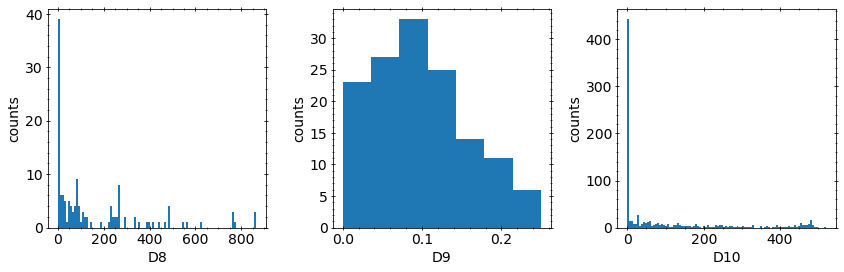

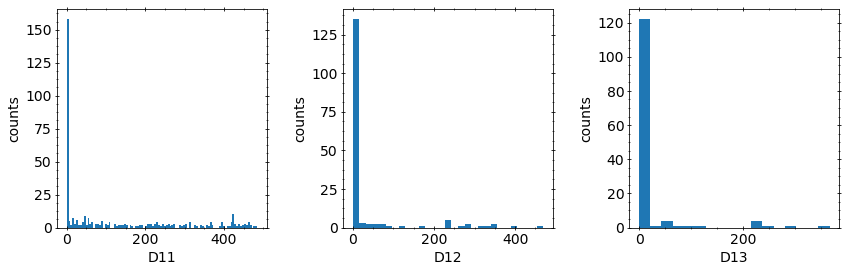

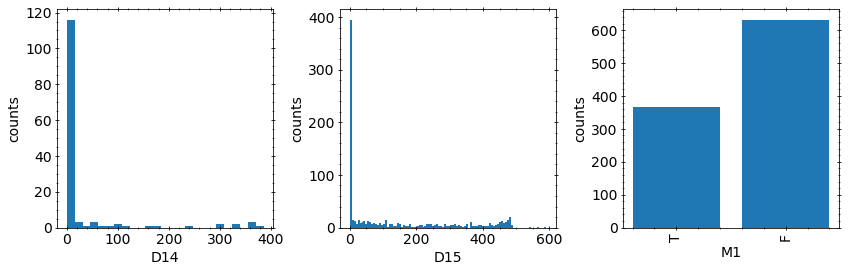

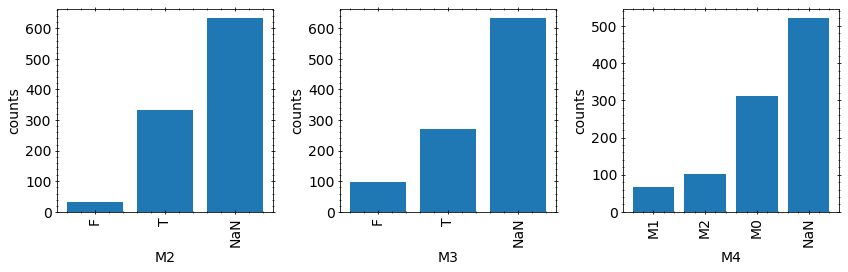

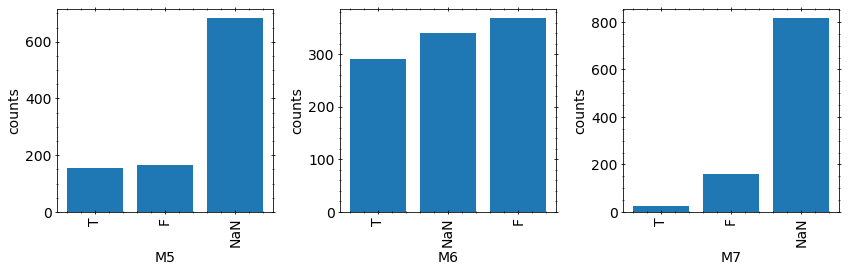

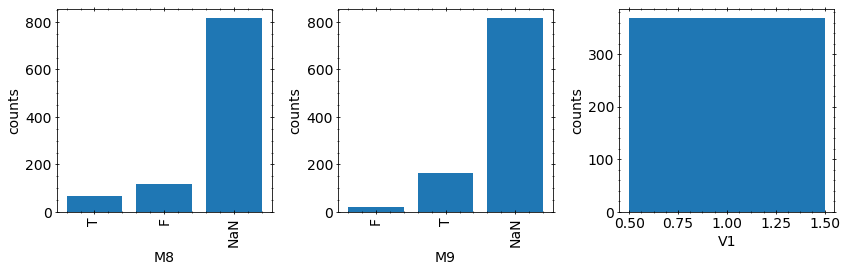

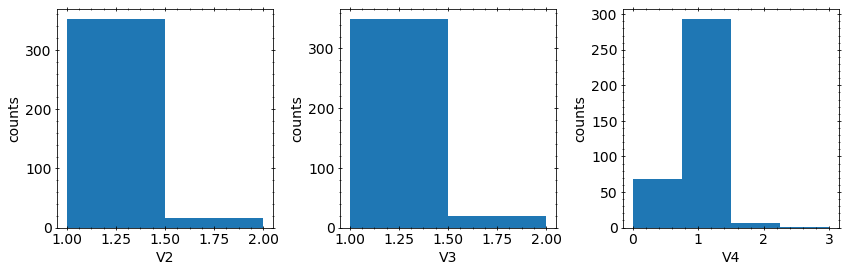

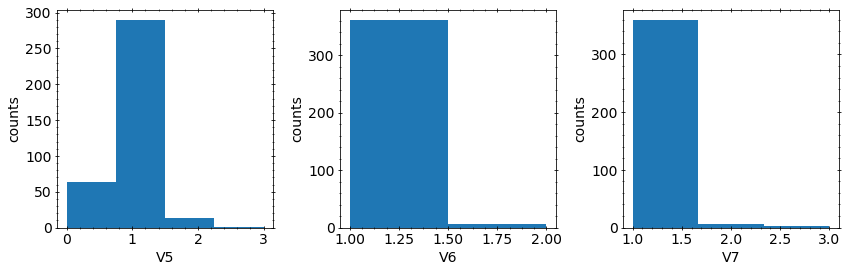

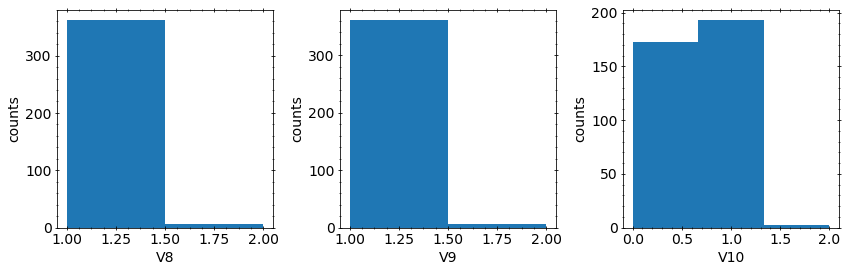

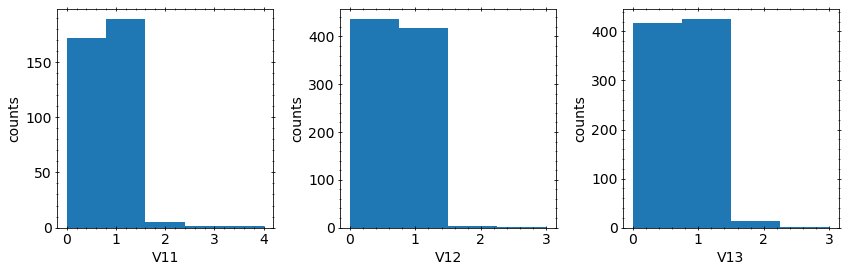

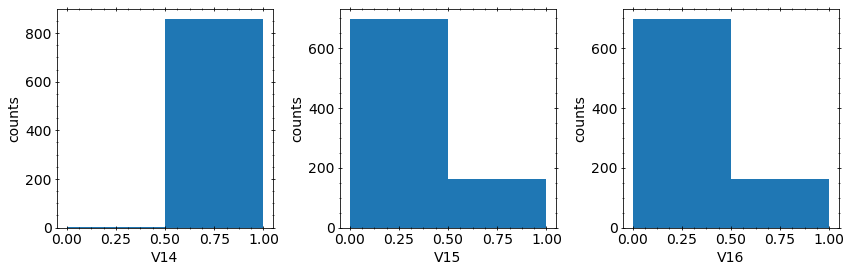

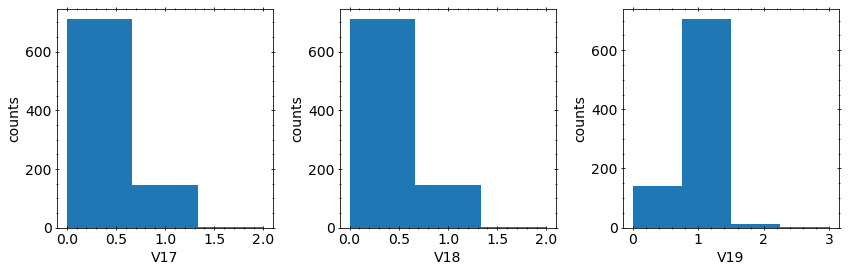

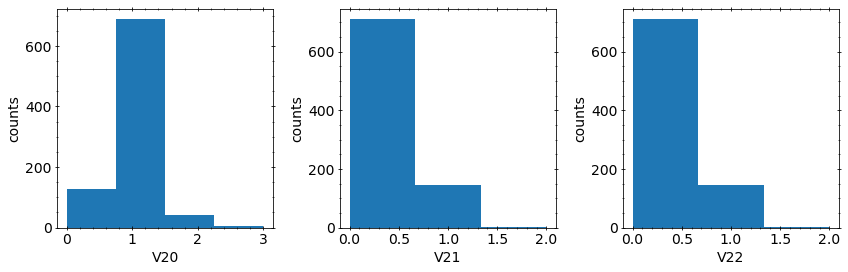

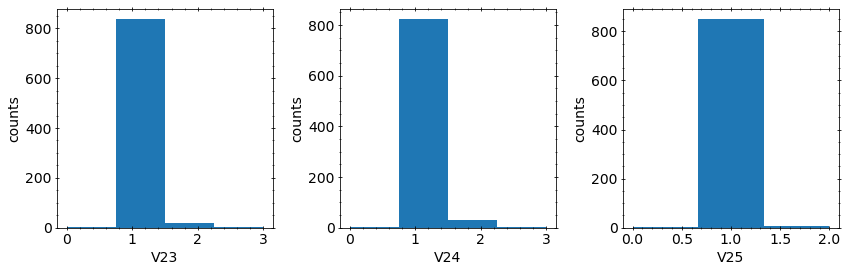

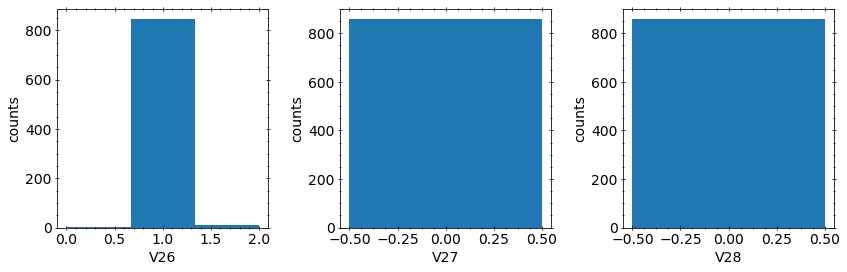

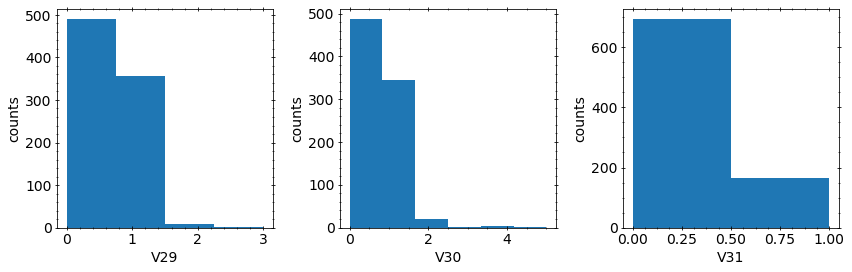

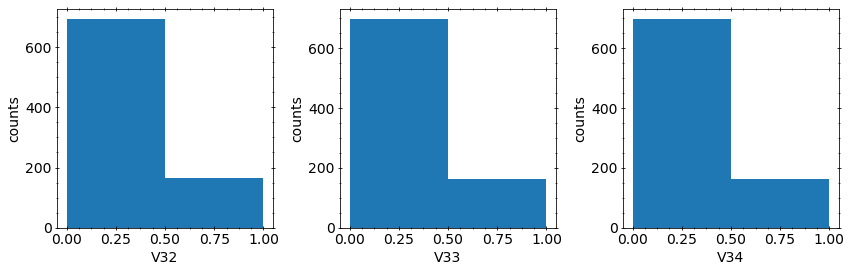

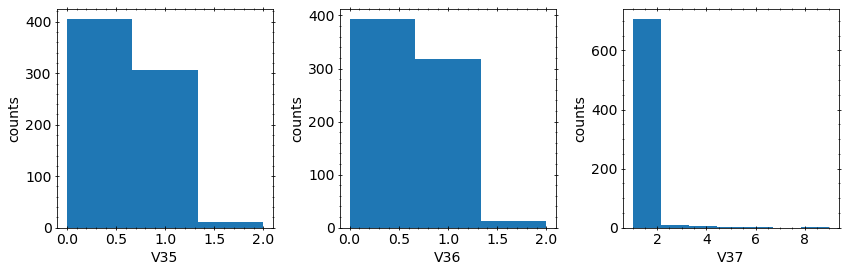

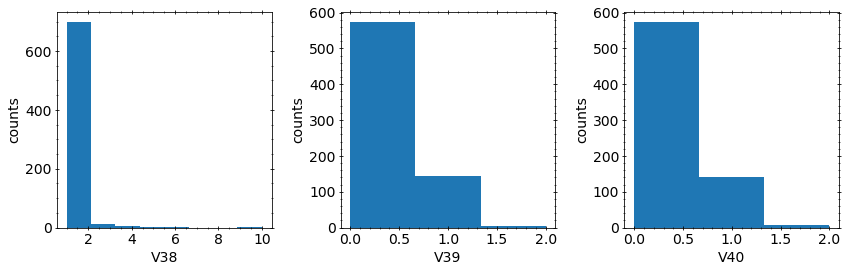

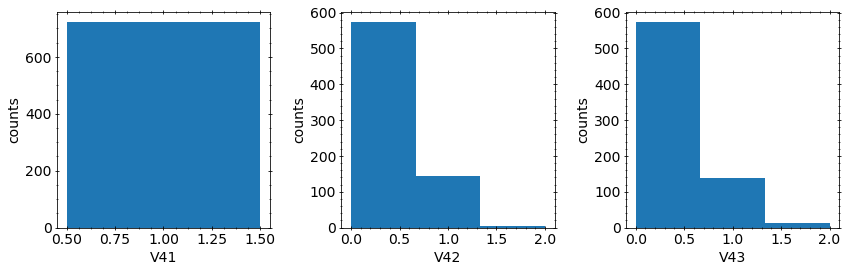

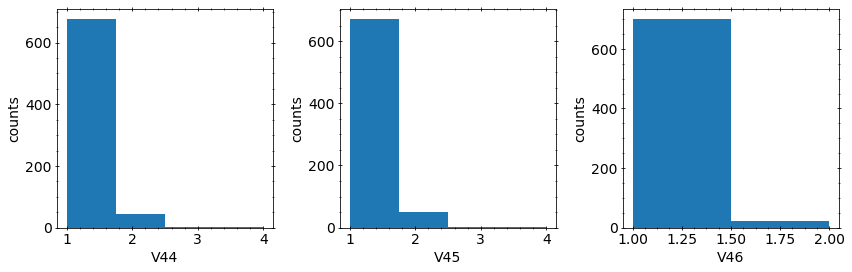

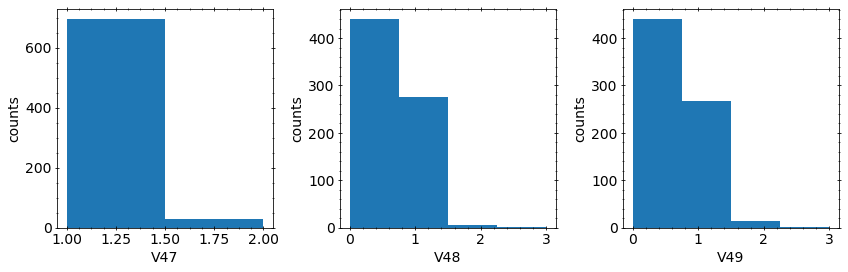

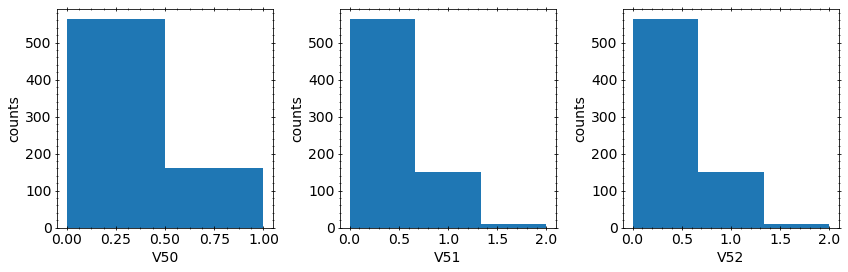

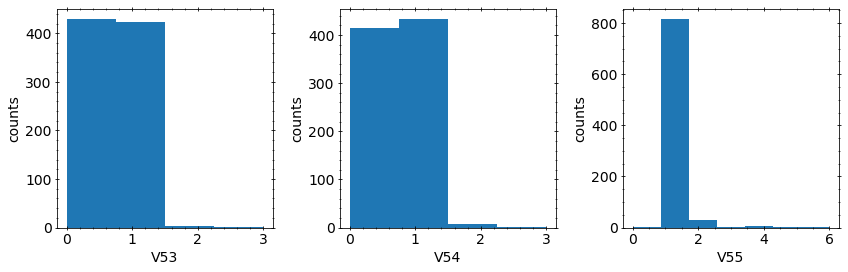

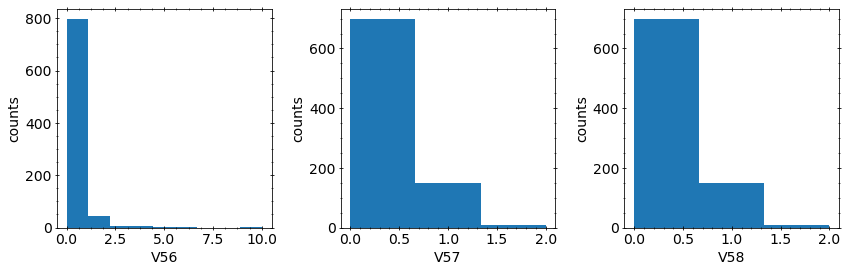

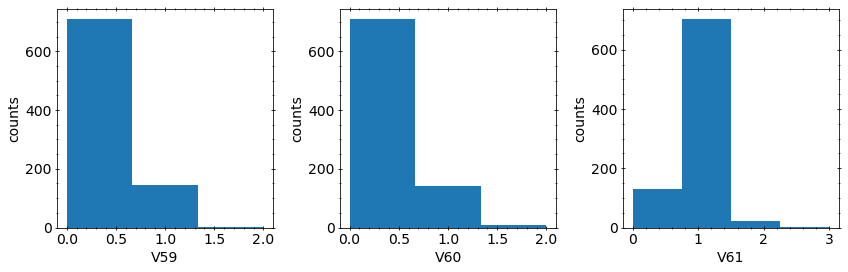

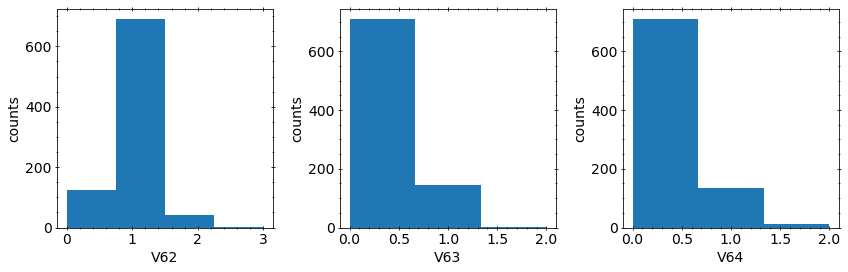

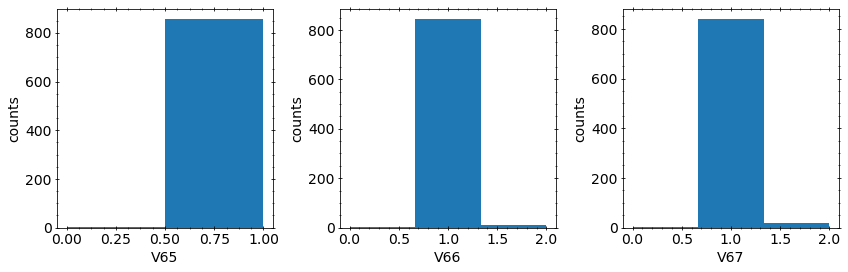

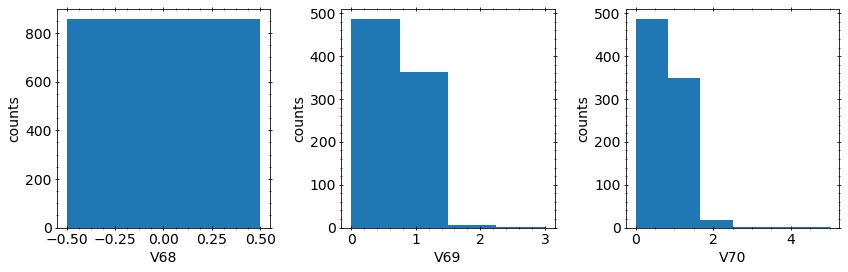

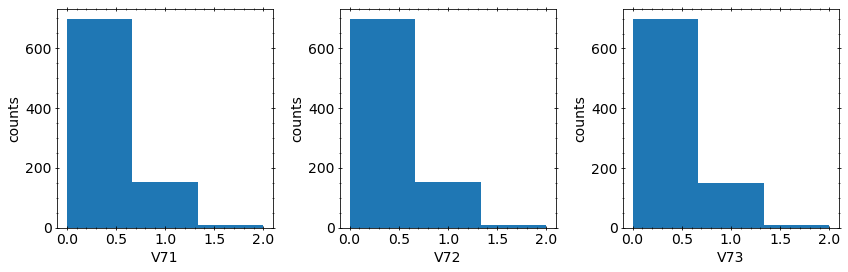

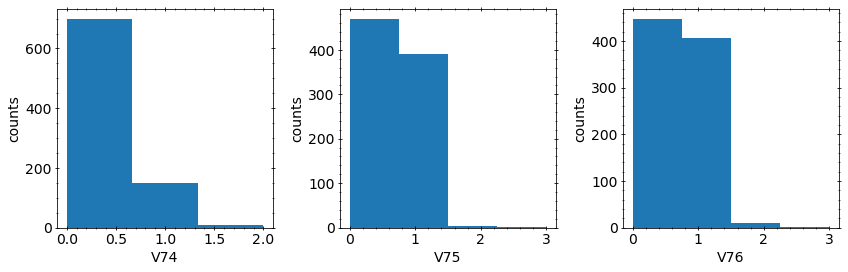

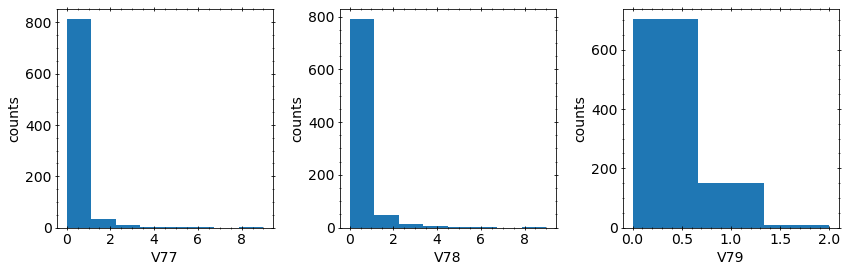

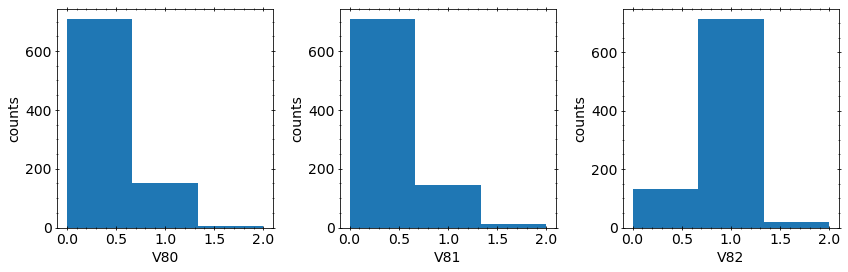

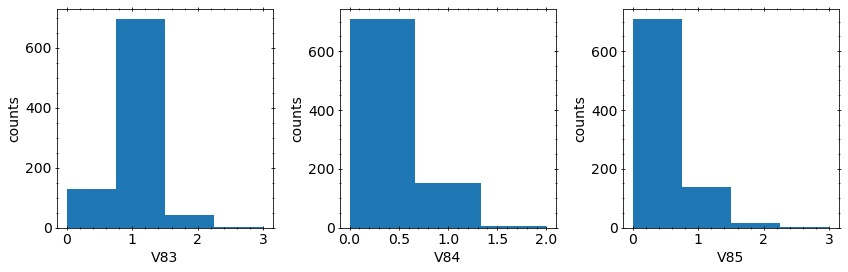

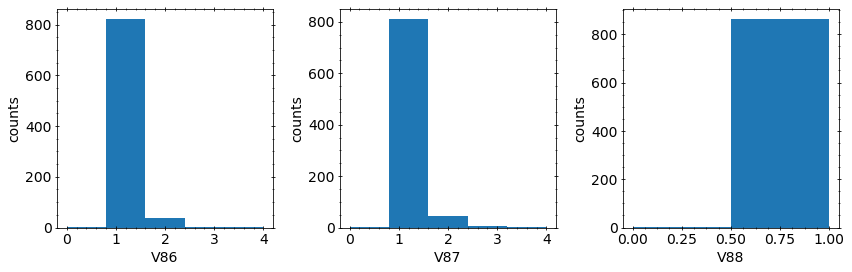

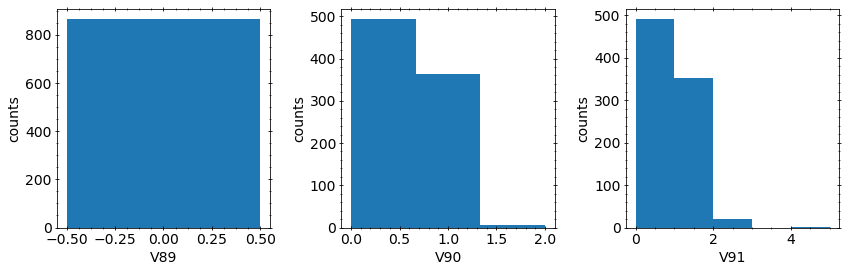

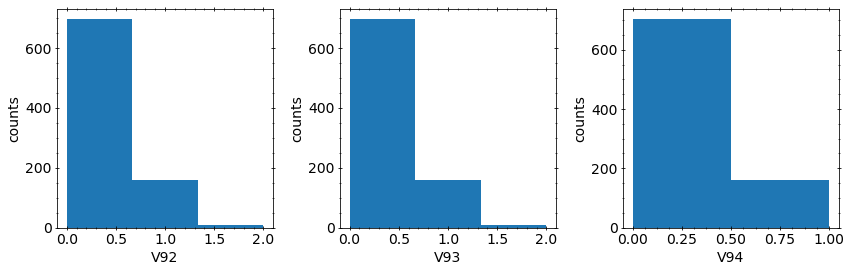

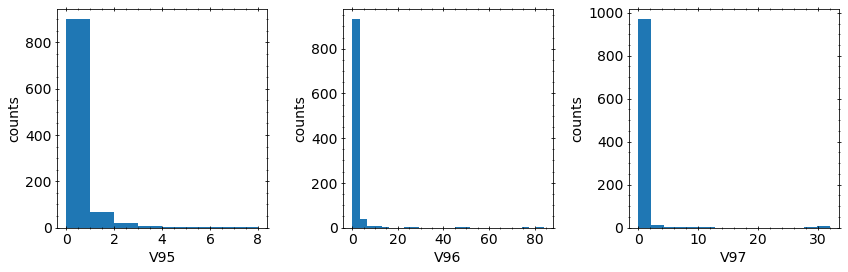

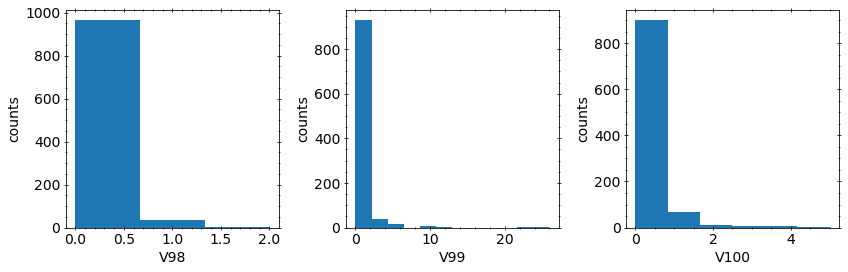

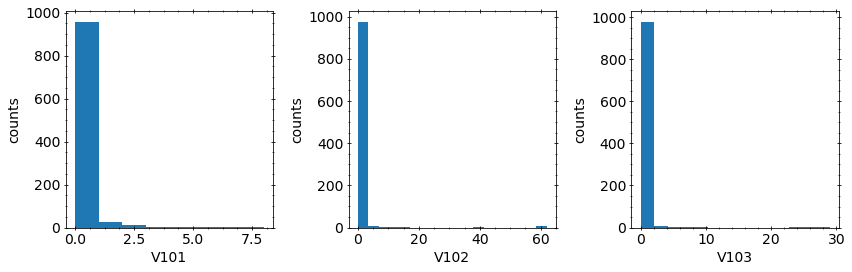

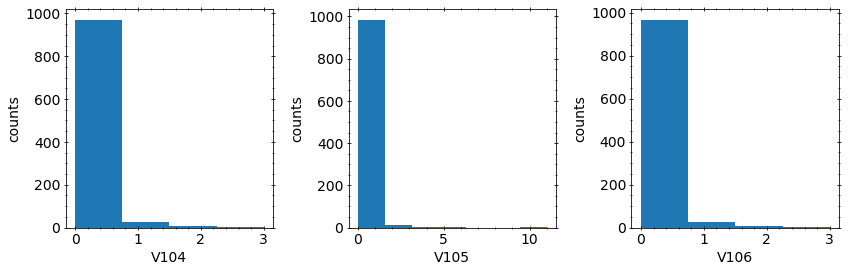

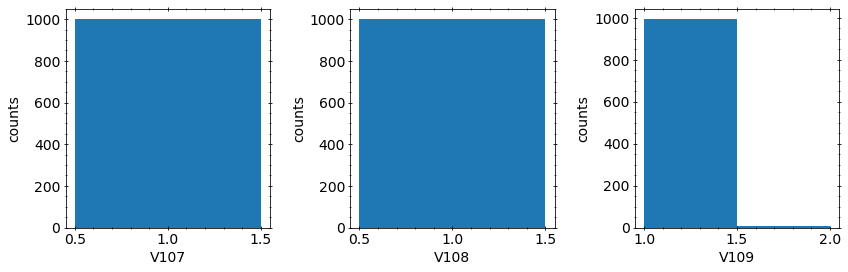

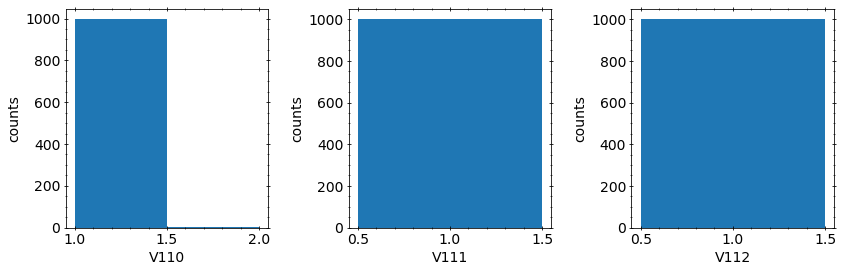

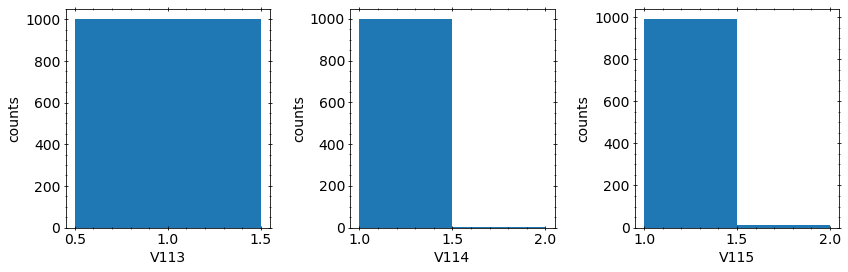

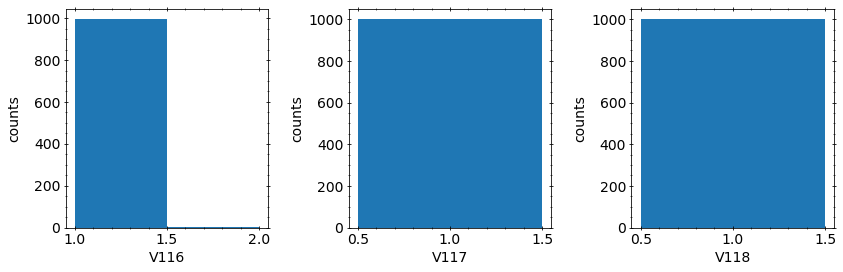

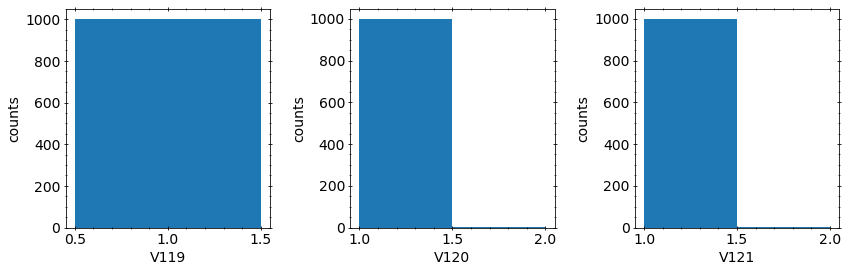

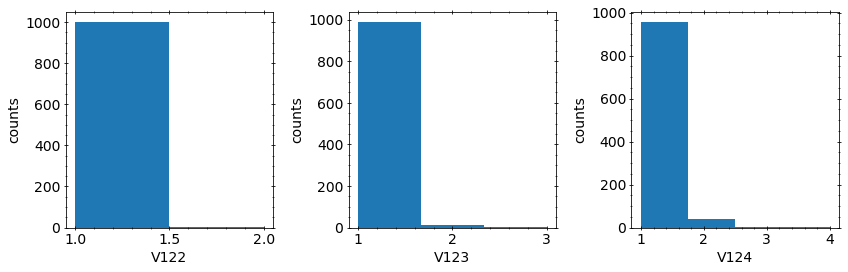

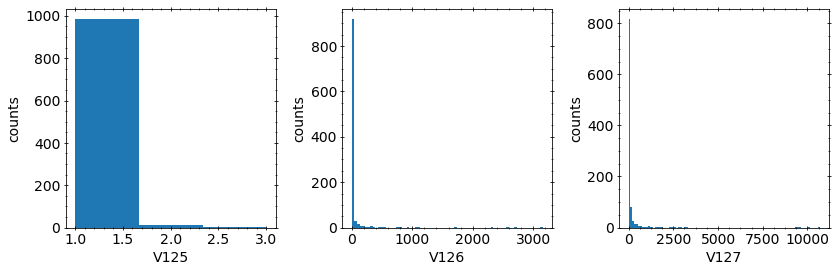

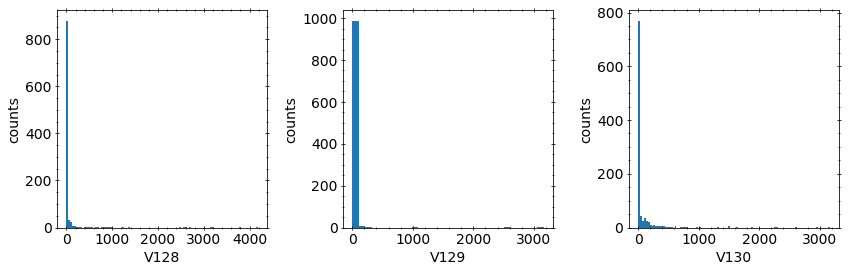

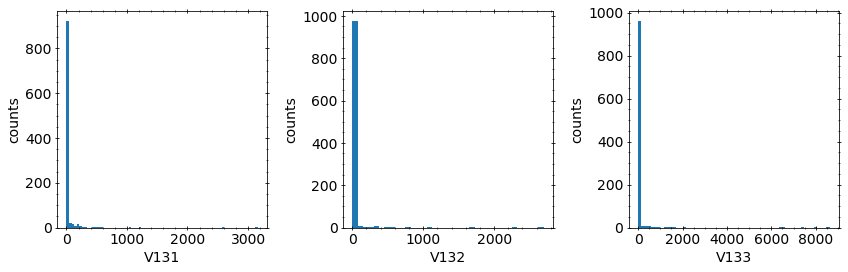

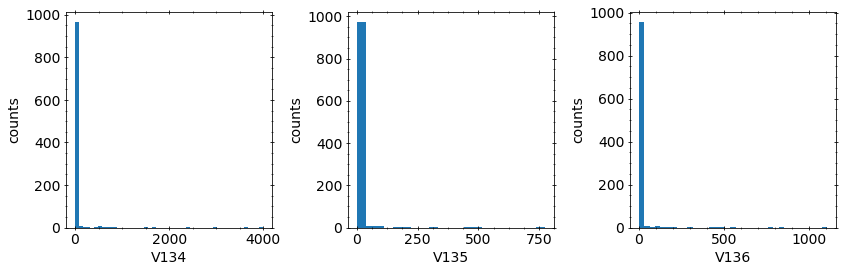

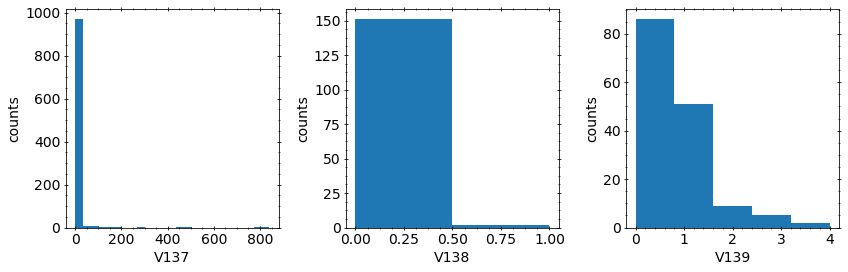

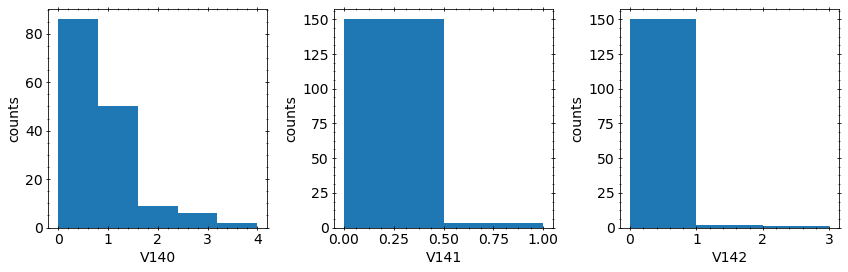

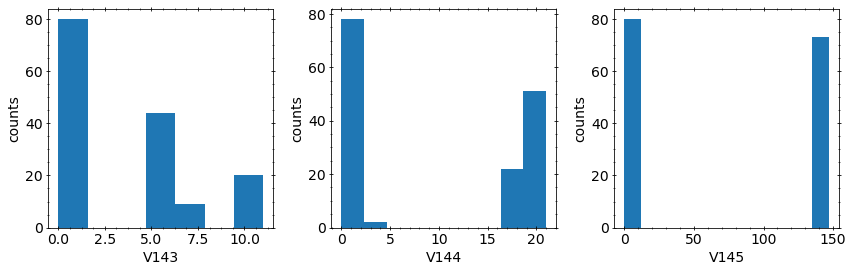

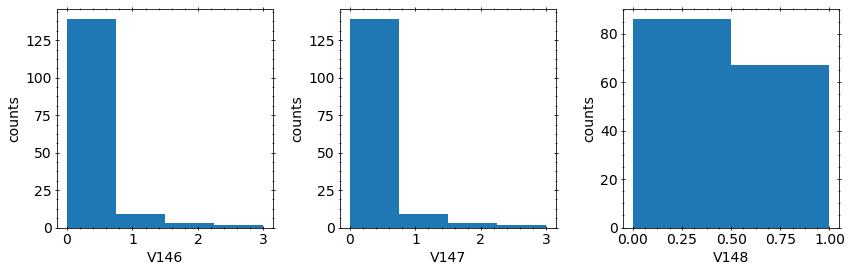

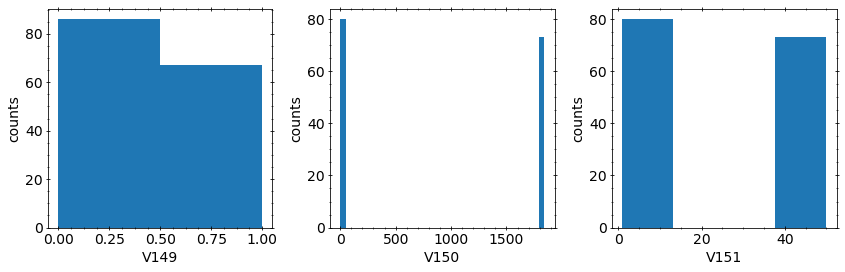

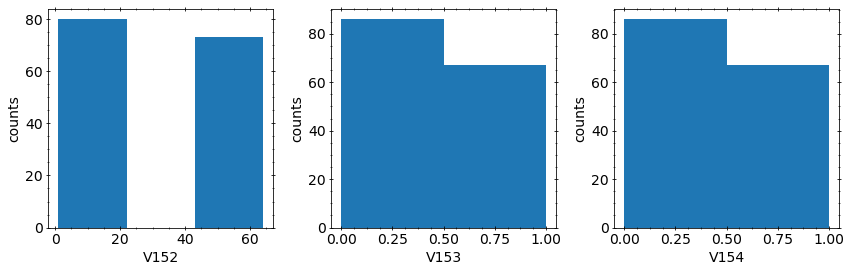

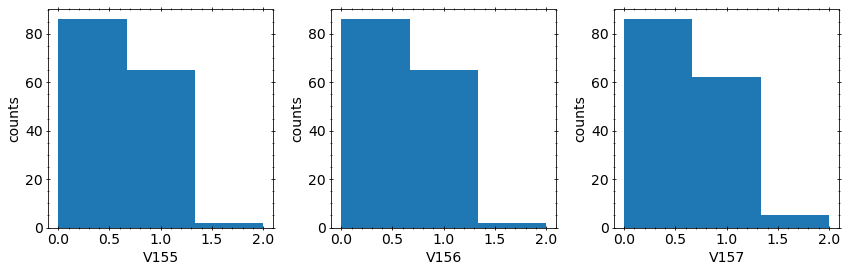

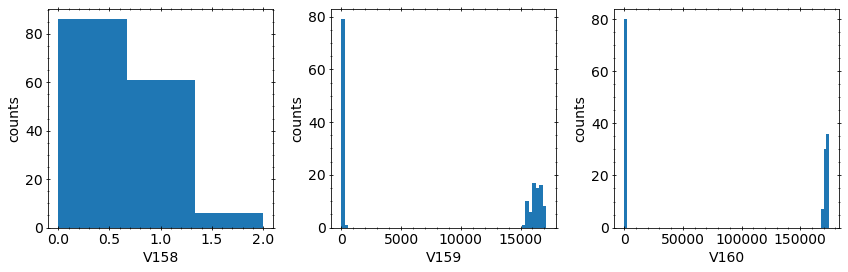

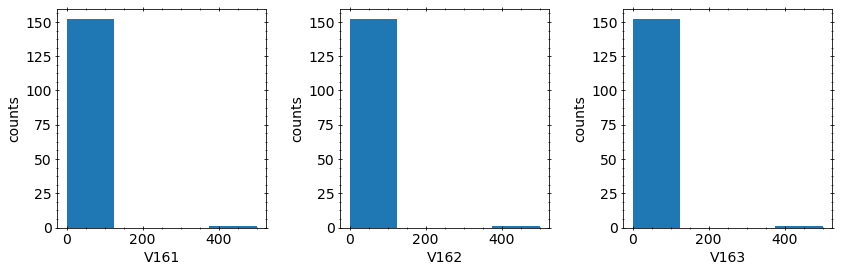

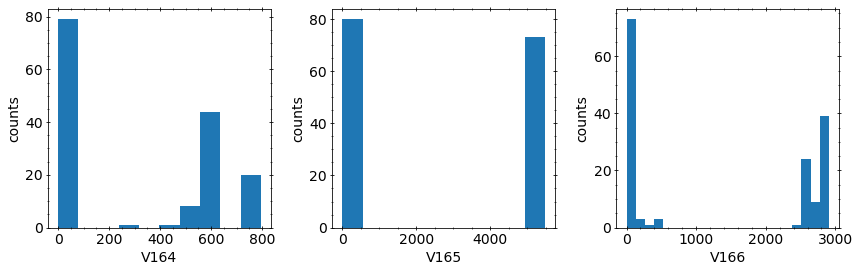

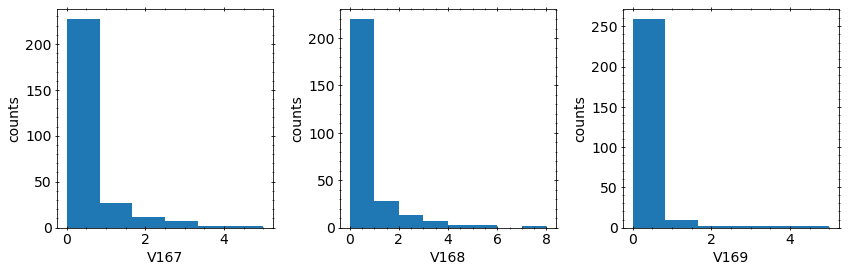

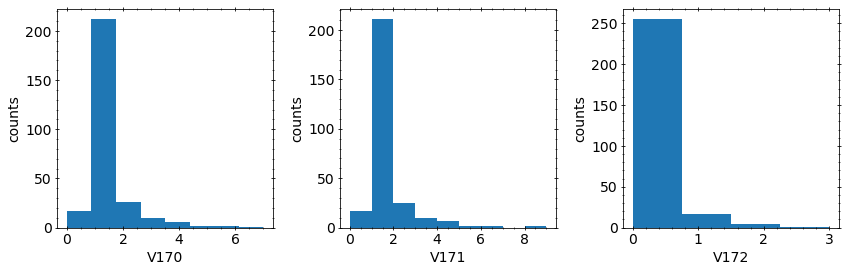

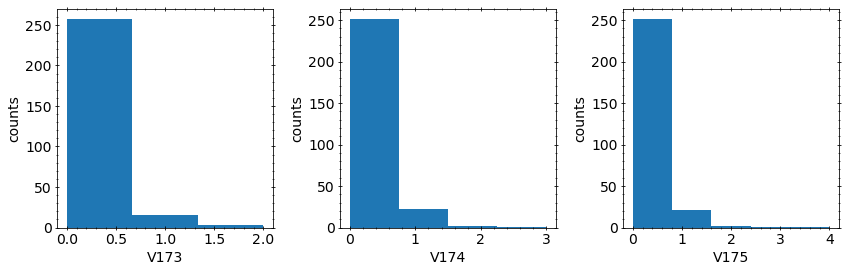

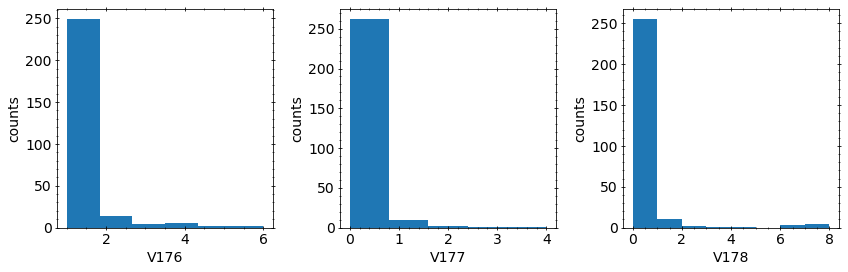

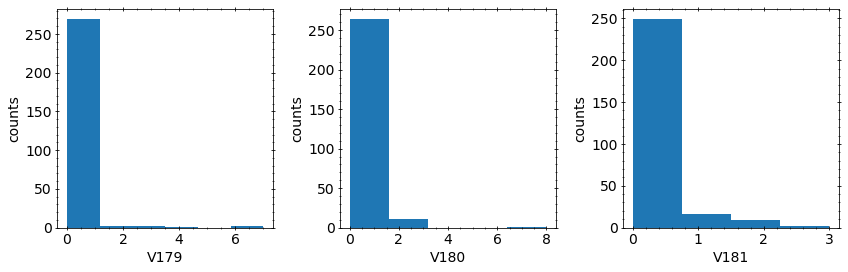

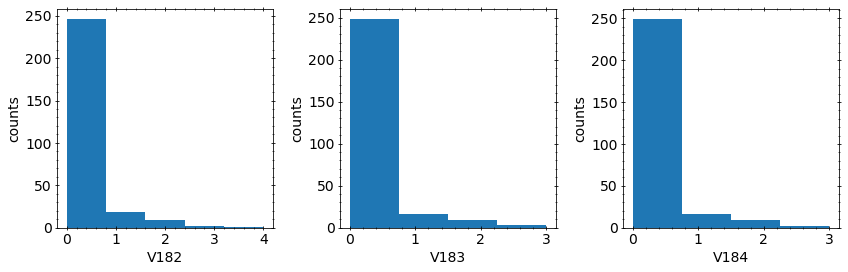

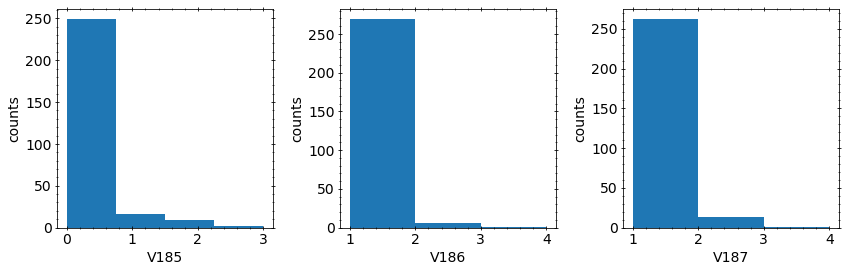

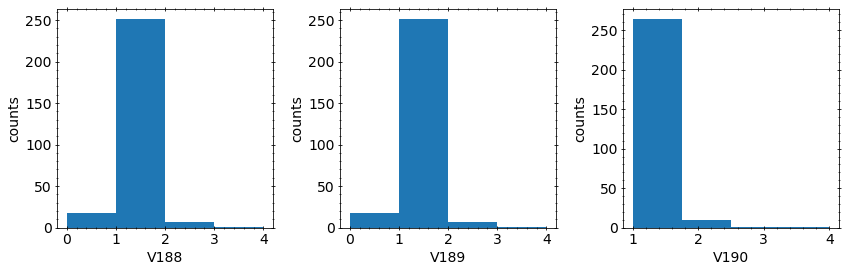

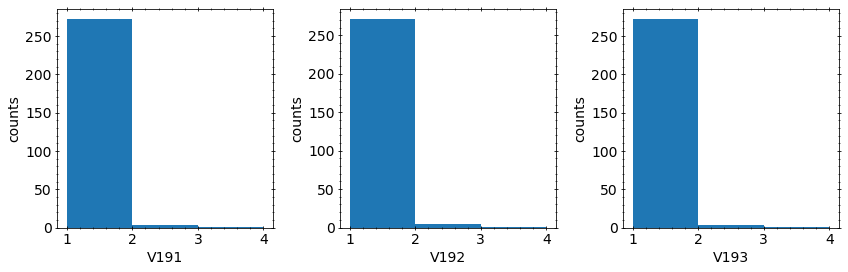

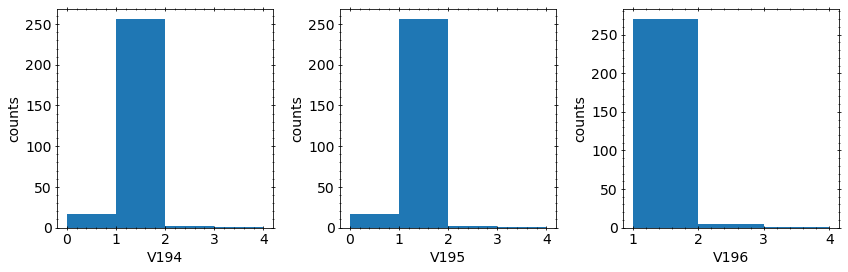

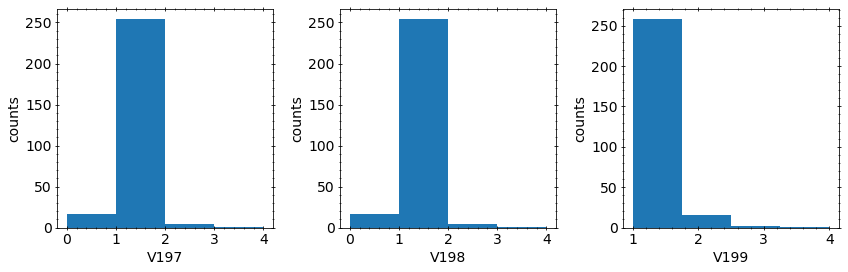

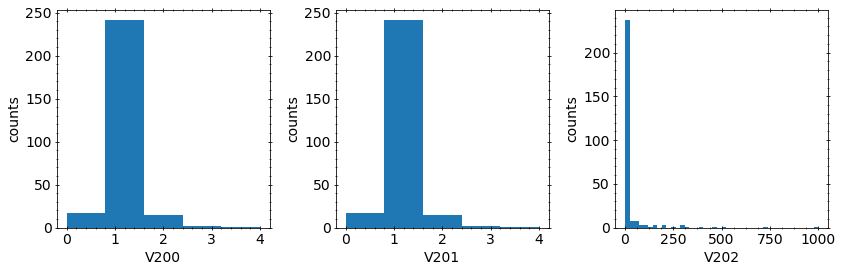

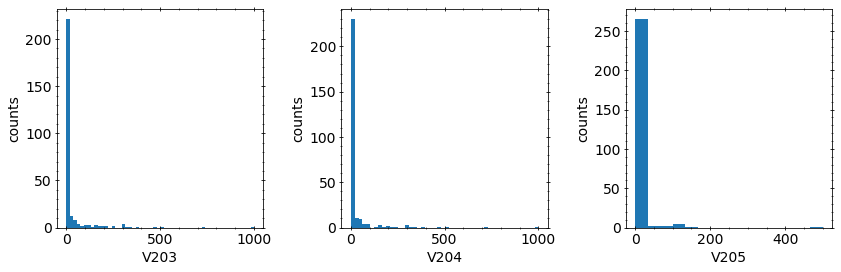

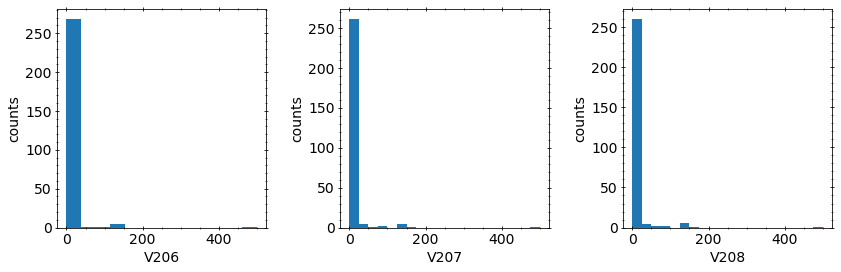

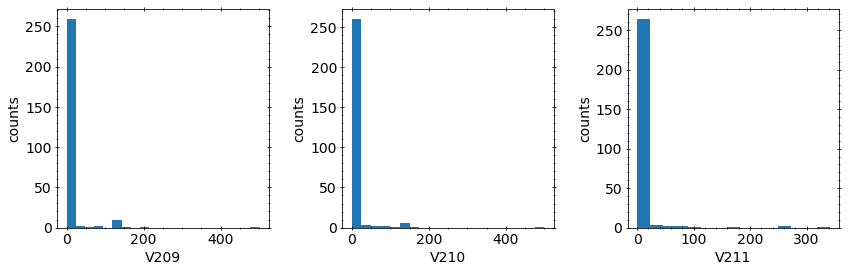

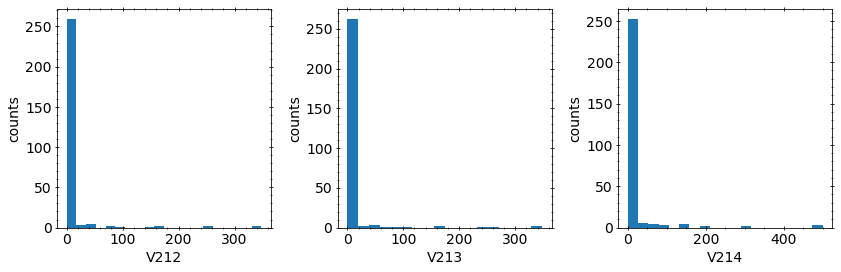

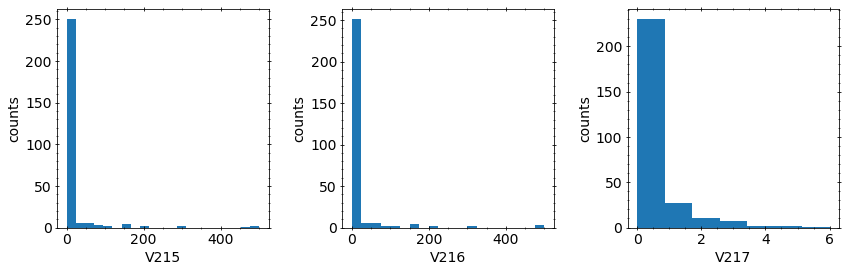

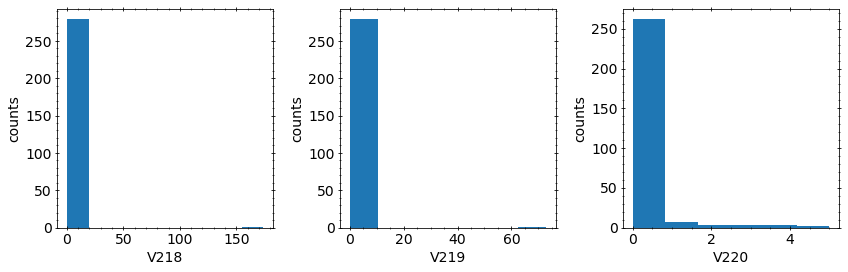

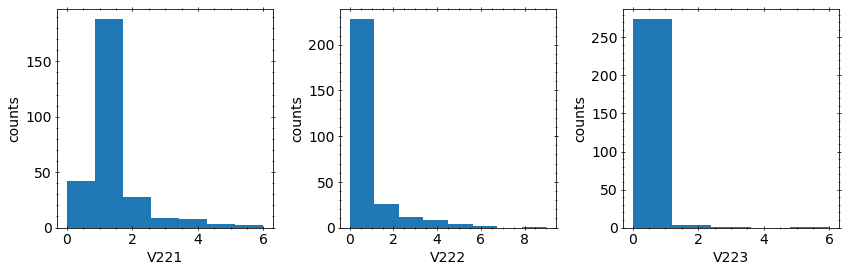

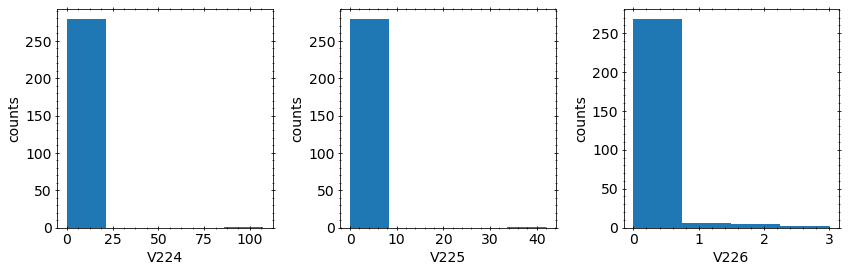

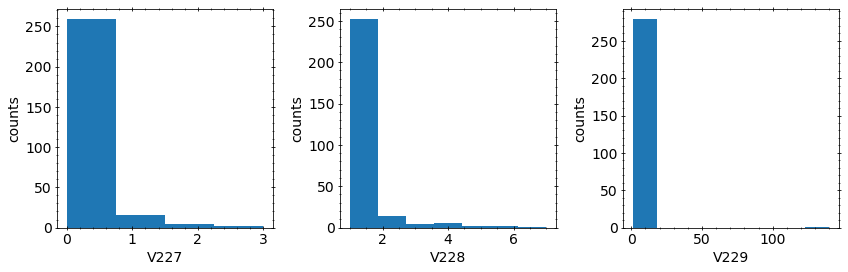

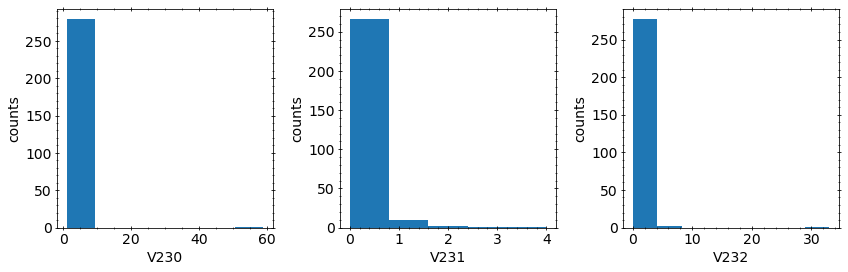

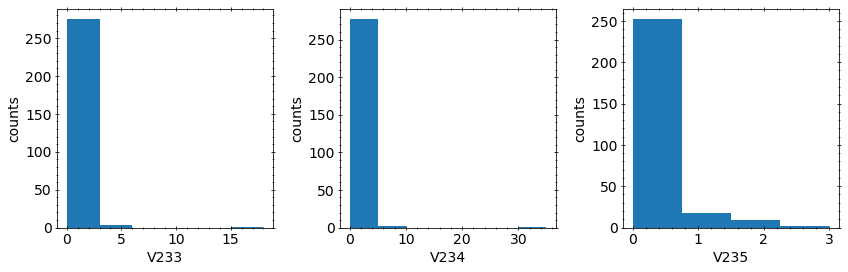

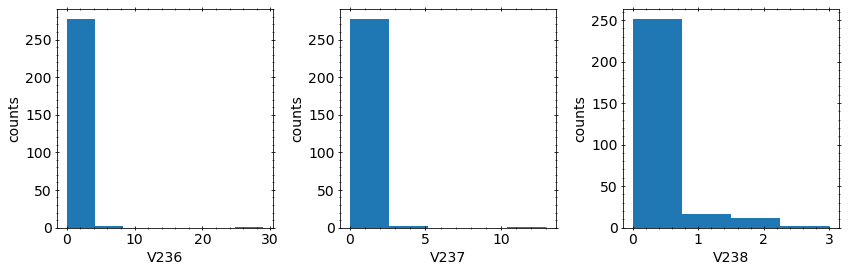

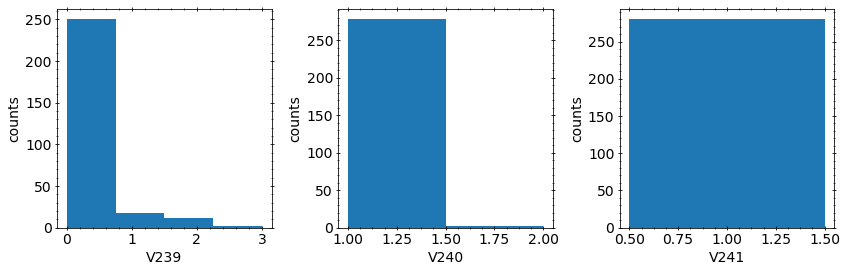

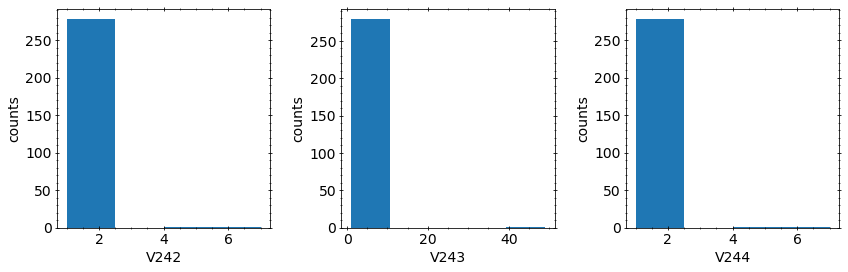

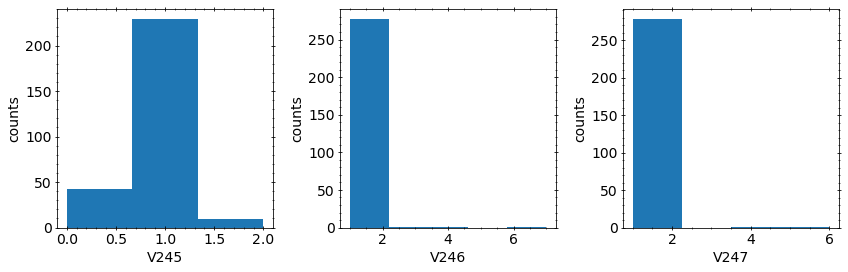

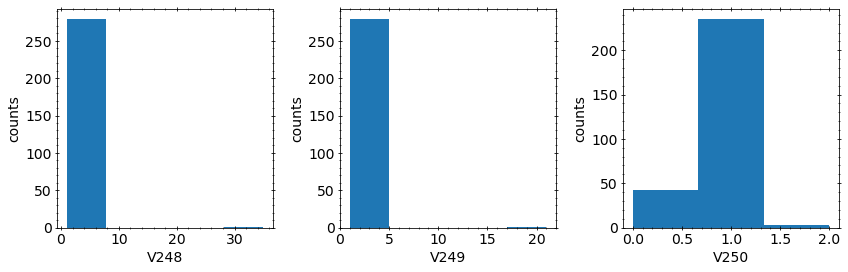

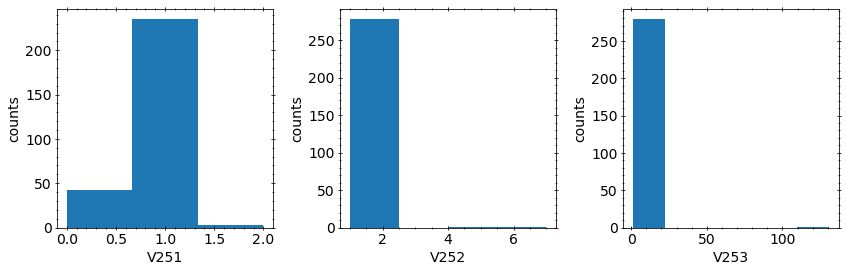

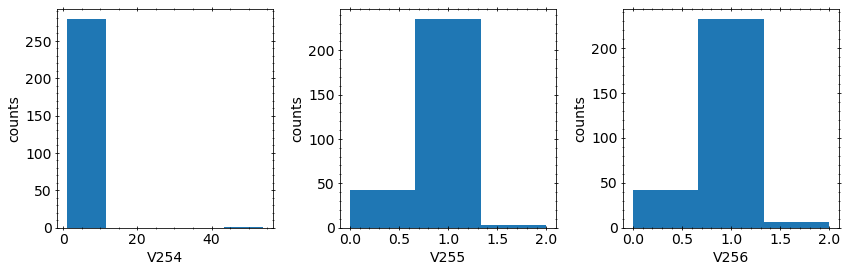

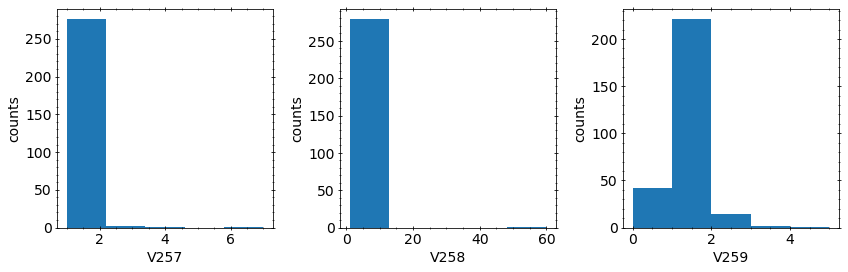

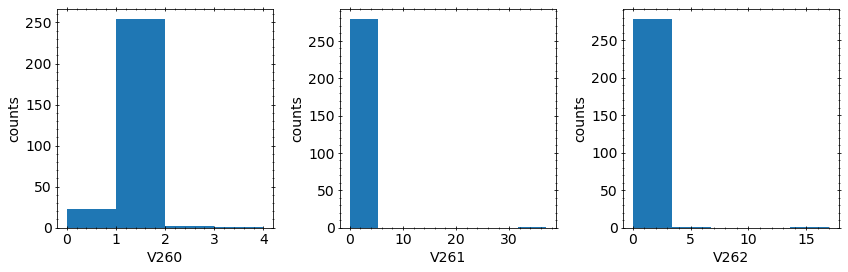

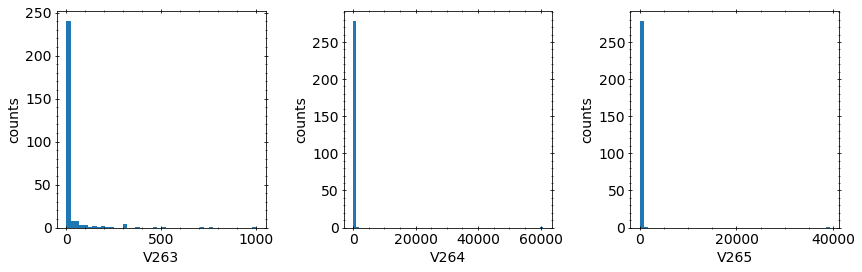

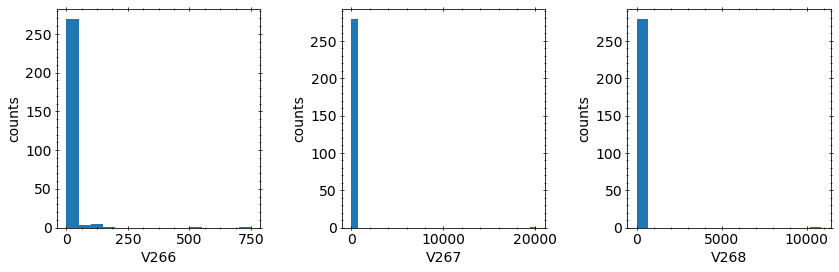

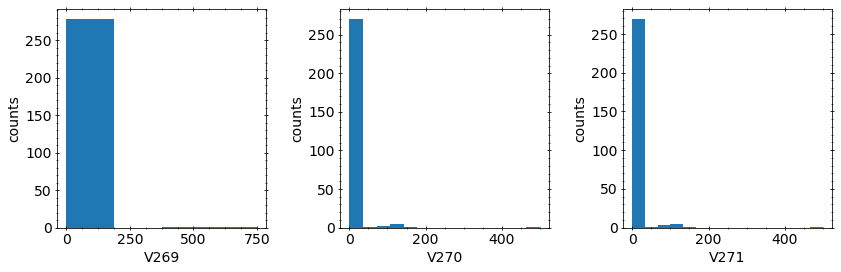

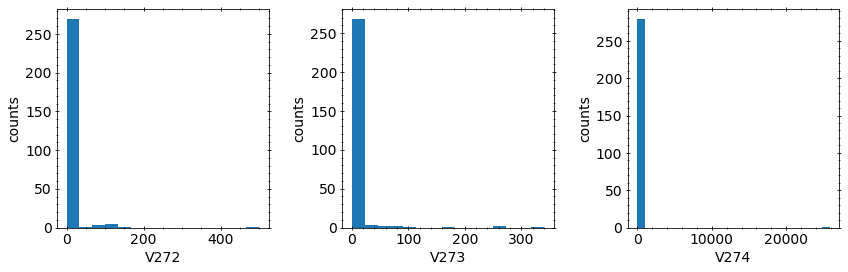

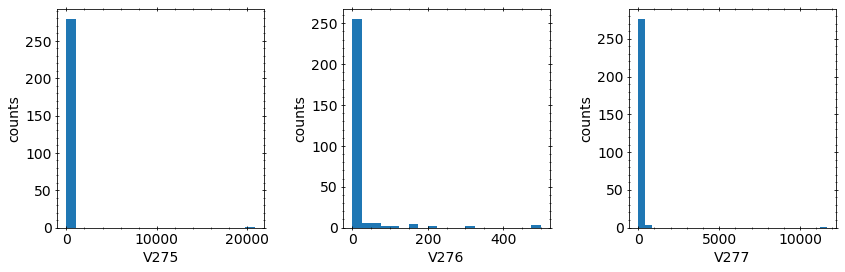

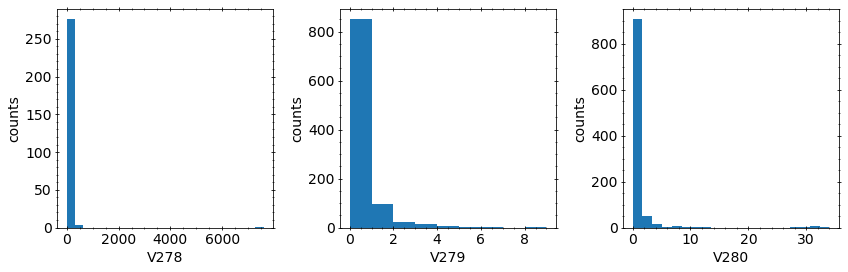

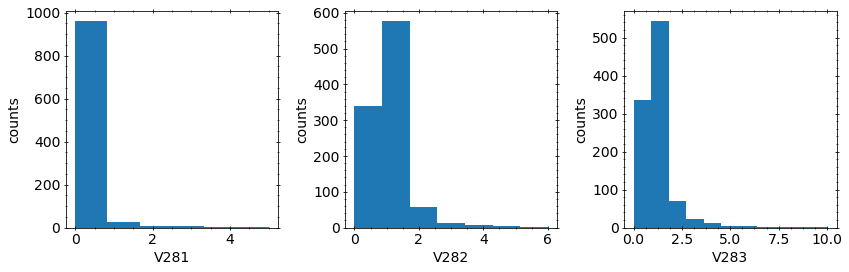

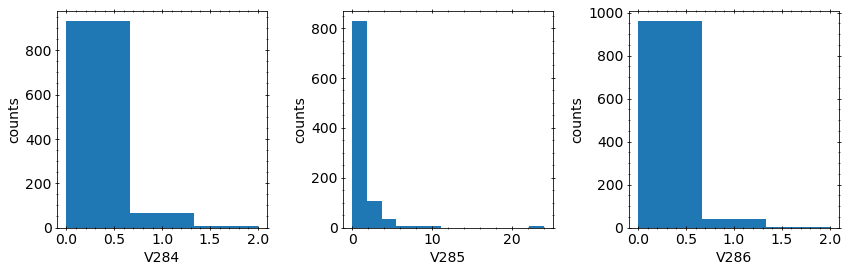

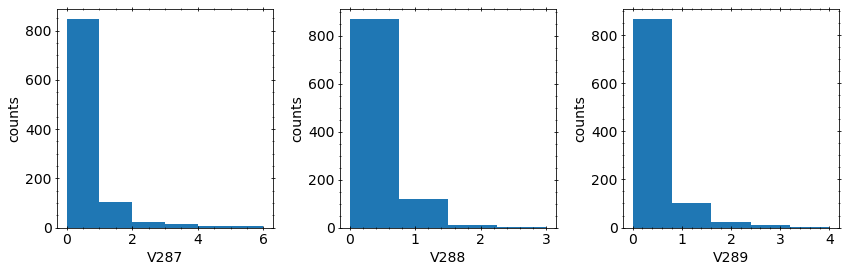

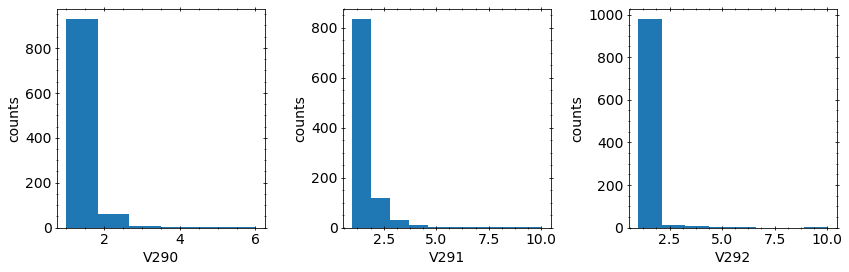

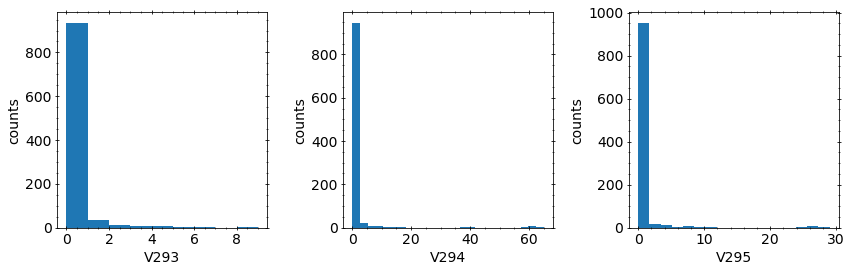

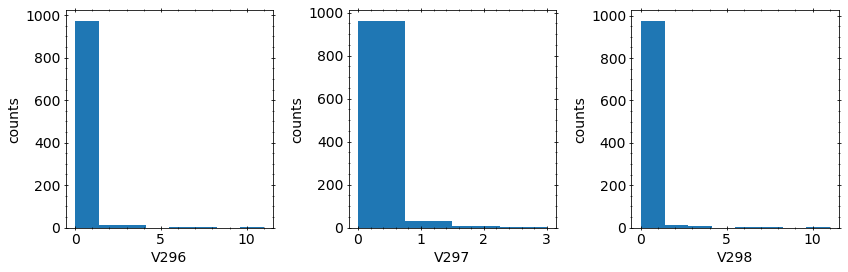

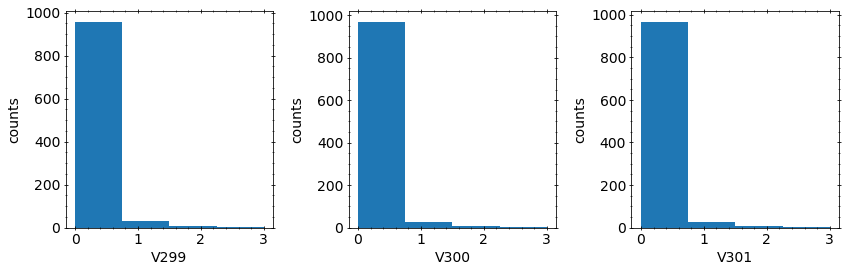

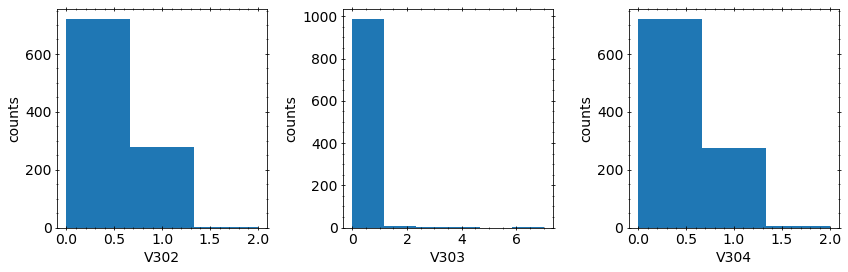

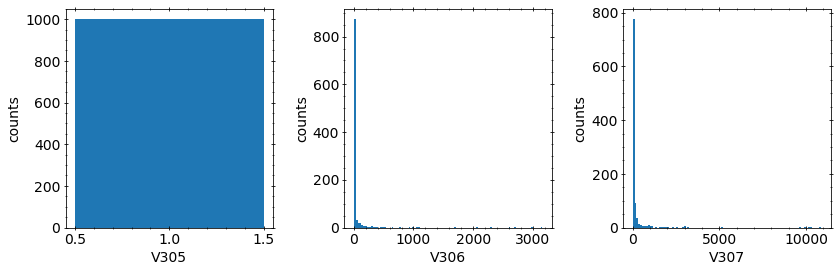

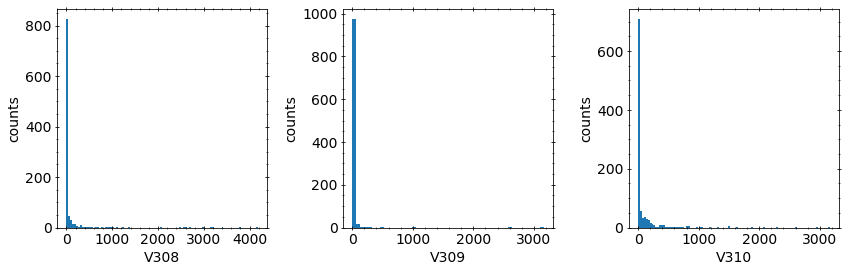

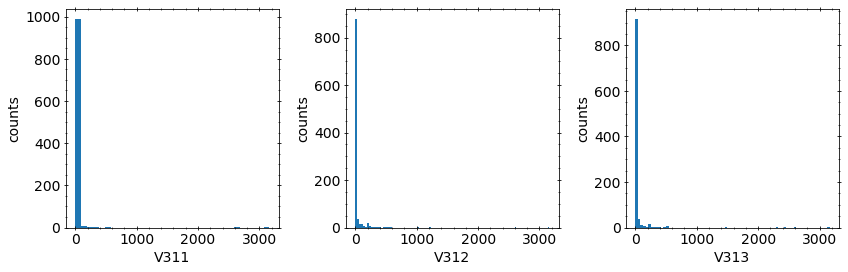

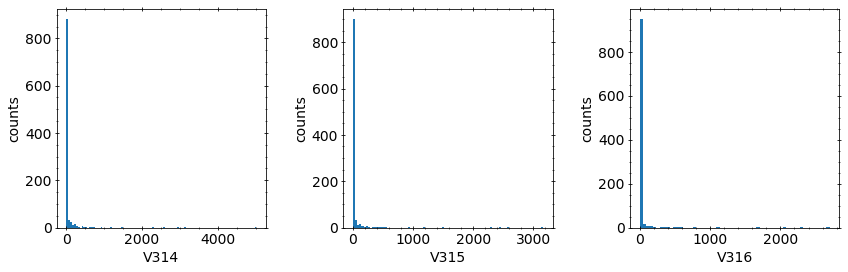

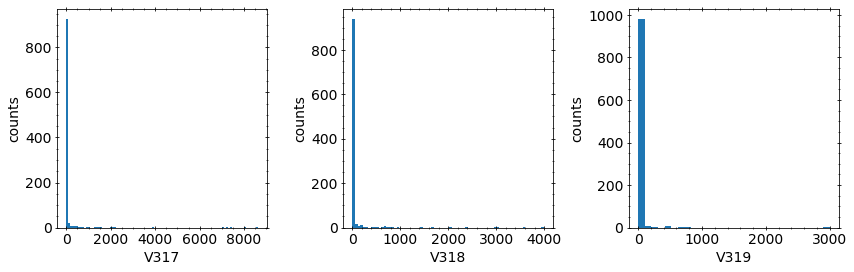

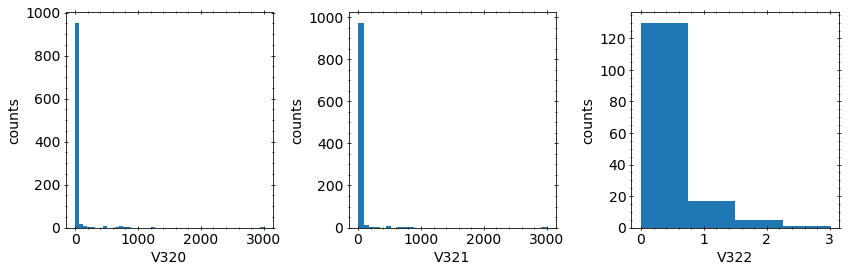

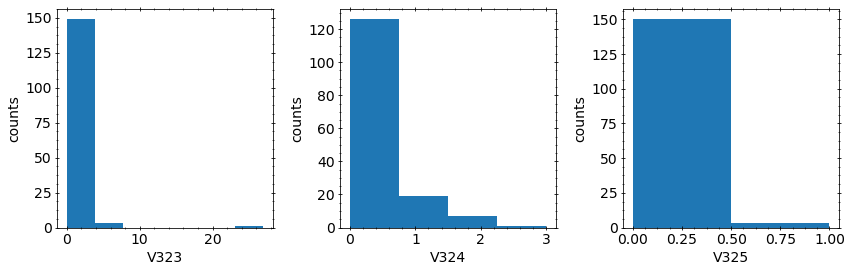

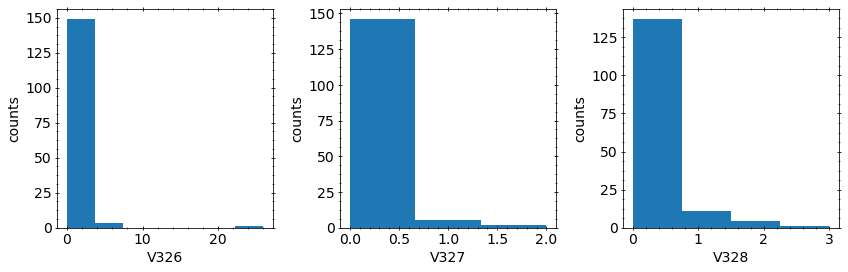

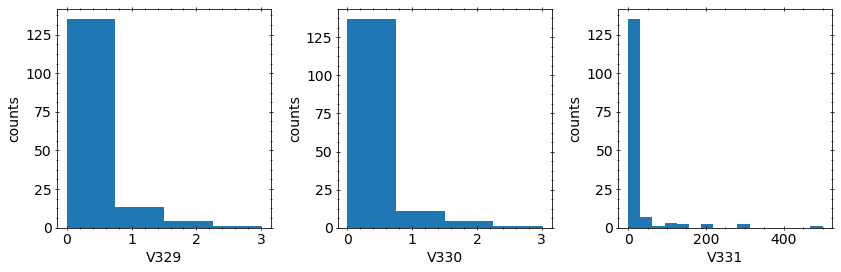

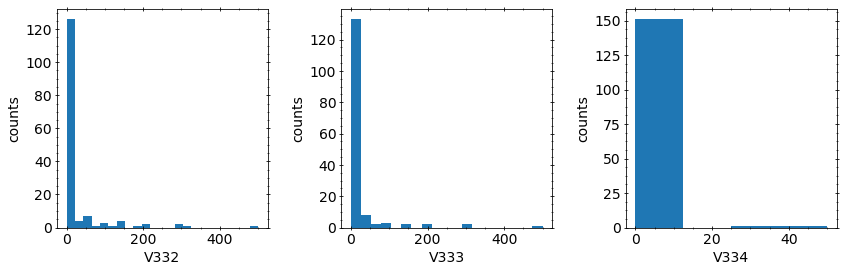

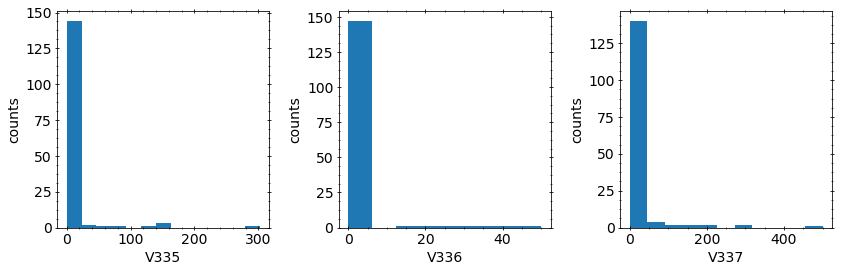

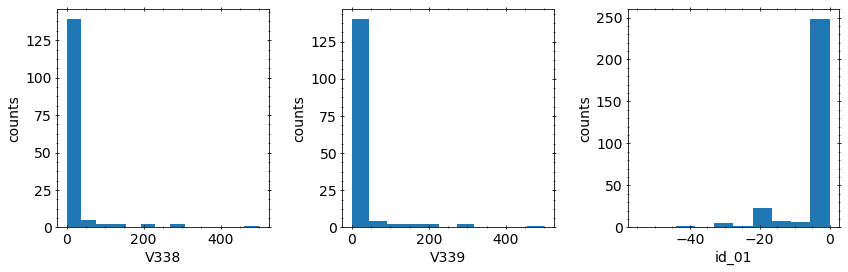

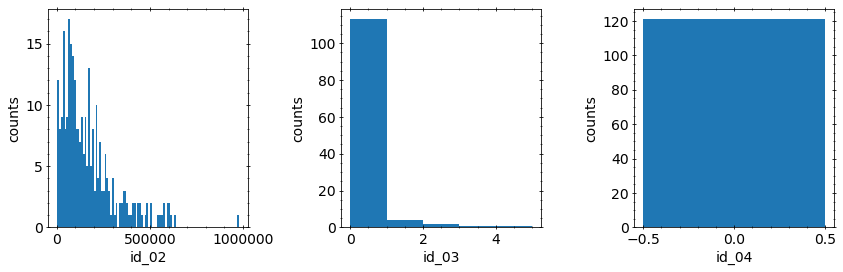

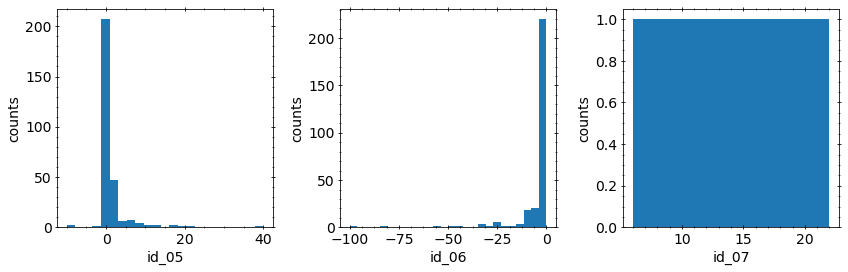

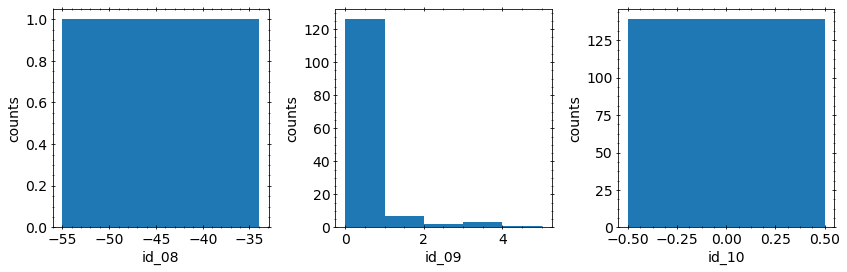

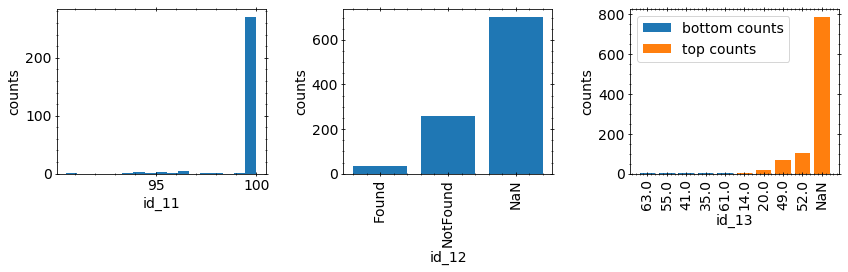

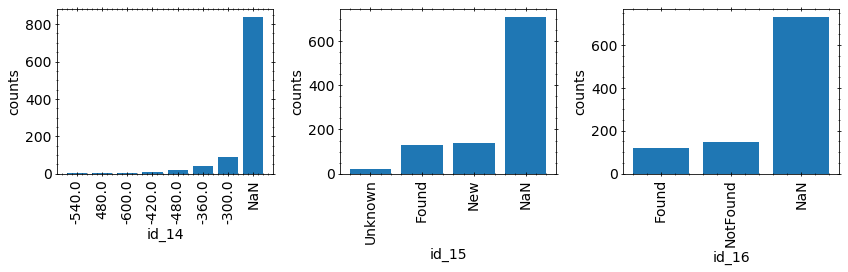

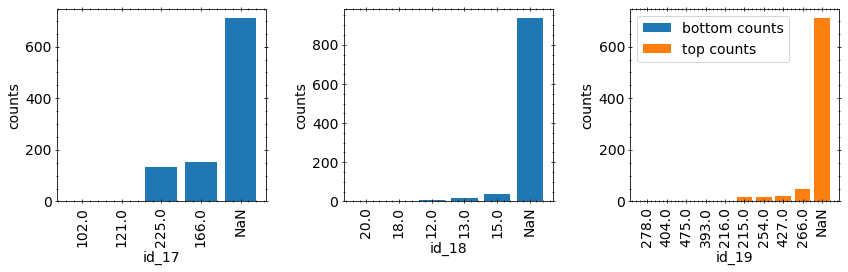

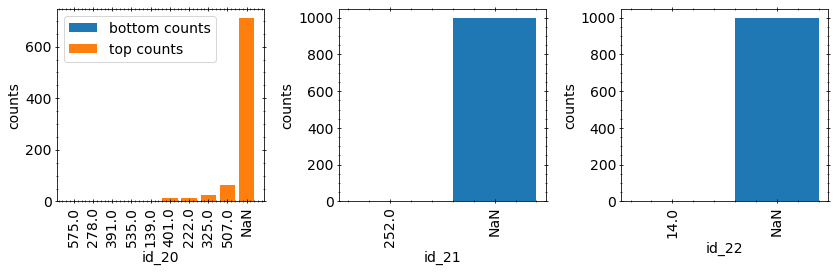

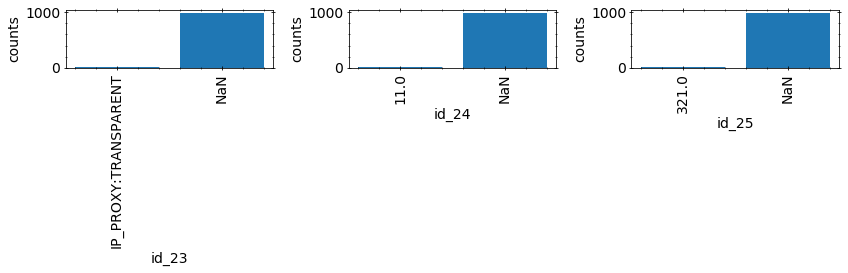

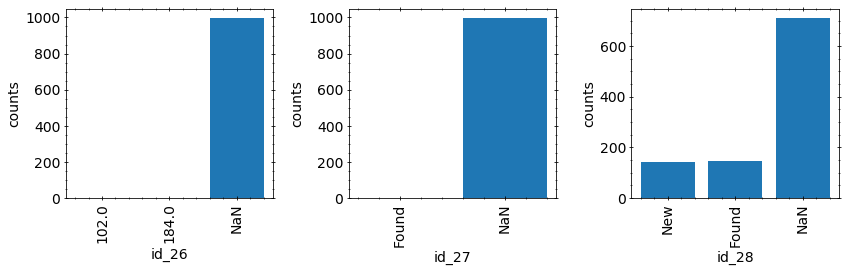

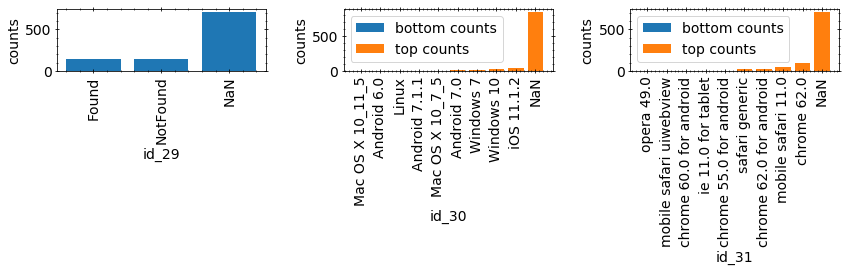

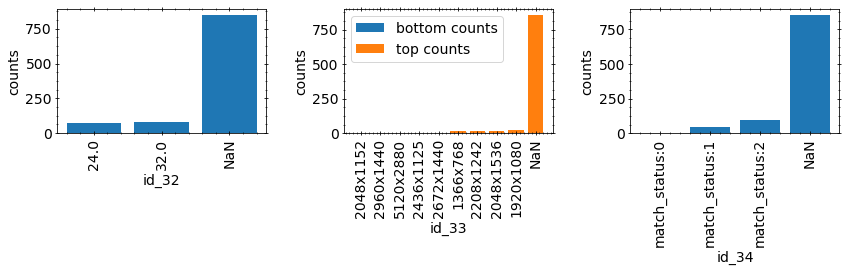

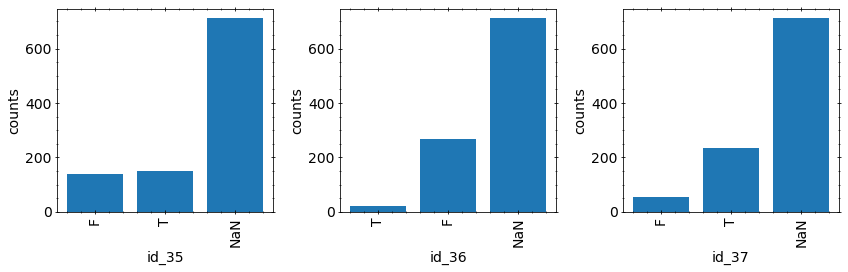

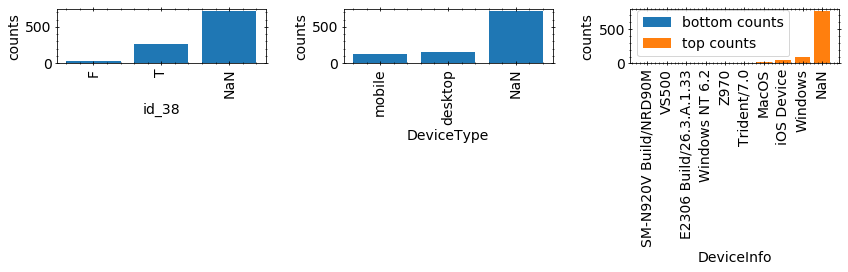

In [58]:
JLpyUtils.plot.hist_or_bar(X, categorical_headers= headers_dict['categorical features'])

In [14]:
y.head()

,isFraud
0,0
1,0
2,0
3,0
4,0


/opt/conda/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


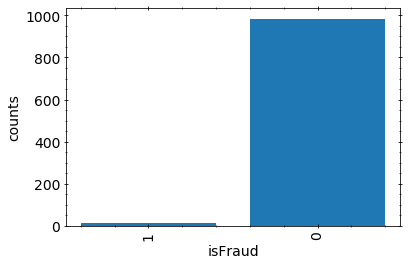

In [15]:
JLpyUtils.plot.hist_or_bar(y, categorical_headers= ['isFraud'], n_plot_columns=1)

# Feature Engineering

## Load the Training Set

In [16]:
importlib.reload(JLpyUtils)
importlib.reload(JLpyUtils.file_utils)
importlib.reload(JLpyUtils.ML)
importlib.reload(JLpyUtils.ML.preprocessing)
importlib.reload(JLpyUtils.ML.preprocessing.LabelEncode)
importlib.reload(JLpyUtils.ML.preprocessing.Scale)
importlib.reload(JLpyUtils.ML.preprocessing.Impute)
importlib.reload(JLpyUtils.ML.preprocessing.OneHotEncode)

df = load_df(path_raw_data_dir, train_test_id = 'train')

In [17]:
#slice out subset for code dev
df = df.partitions[0]

In [18]:
X = df[headers_dict['features']]
y = df[headers_dict['labels']]

X = basic_feat_cleaner(X)

display(X.head())

del df
gc.collect()
None

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0

## Instantiate The Feature Engineering Pipe

The ```JLpyUtils.ML.preprocessing.feat_eng_pipe``` class is designed to streamline & automate running various feature engineering operations. The feature engineering sequence is:
1. LabelEncode.categorical_features
2. Scale.continuous_features
    * for Scaler_ID in Scalers_dict.keys()
3. Impute.categorical_features
    * for Imputer_cat_ID in Imputer_categorical_dict[Imputer_cat_ID].keys():<br>
        *for Imputer_iter_class_ID in Imputer_categorical_dict[Imputer_cat_ID].keys():
4. Imputer.continuous_features
    * for Imputer_cont_ID in Imputer_continuous_dict.keys():
        * for Imputer_iter_reg_ID in Imputer_continuous_dict[Imputer_cont_ID].keys():
5. OneHotEncode
6. CorrCoeffThreshold

For many of these operations, there are various hyperparameters that could be varied to perform similar but different types of feature engineering. The default settings in the class are setup to allow one to ultimately perform model training on data sets that have different types of scaling, or imputation, etc.. applied. However, for simplicy, and because this dataset is quite large, we will just focus on one feature engineering pipe scenario

In [19]:
feat_eng_pipe = JLpyUtils.ML.preprocessing.feat_eng_pipe(path_report_dir = path_desktop, 
                                                              verbose=1, 
                                                              overwrite=False)

/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Define Single Feature engineering case to evaluate

We could iterate through all possible feature engineering scenarios, but this dataset is quite large and that would take quite a bit of time, so we will just evaluate one promising scenario

In [20]:
import sklearn.preprocessing
import sklearn.linear_model

feat_eng_pipe.Scalers_dict = {'MinMaxScaler': sklearn.preprocessing.MinMaxScaler()}
feat_eng_pipe.Imputer_categorical_dict = {'most_frequent': {None: None}}
feat_eng_pipe.Imputer_continuous_dict = {'median':{None:None}}#{ 'iterative': {'BayesianRidge': sklearn.linear_model.BayesianRidge()}}
feat_eng_pipe.OneHot_cases = [True]
feat_eng_pipe.AbsCorrCoeff_thresholds = [1]

## Fit Feat Eng Pipe on X

In [21]:
feat_eng_pipe.fit(X, headers_dict=headers_dict, format_='csv')

del X
gc.collect()
None

-------------------------------- feat_eng_pipe fit --------------------------------
LabelEncode
	Scale: MinMaxScaler
		Impute Categorical Features: most_frequent [ None ]
			Impute Continuous Features: median [ None ]
				One Hot Encode: [ True ]
					CorrCoeffThreshold: [ 1 ]
------------------------------------ !Finished! ------------------------------------


## Transform X_field using Feat Eng Pipe

We call Kaggle's "test" data "field" data, since usually you actually have labels in the "test" data for machine learning problems, and since we don't actually have access to the labels, it's kinda more like testing our model on field data and getting feedback later on have good or bad it did.

In [22]:
df_field = load_df(path_raw_data_dir, train_test_id = 'test')
X_field = df_field[headers_dict['features']]

X_field = basic_feat_cleaner(X_field)

del df_field
gc.collect()
None

In [23]:
if dev: #slice out 1 partition of the data for development
    X_field = X_field.partitions[1]

In [24]:
feat_eng_pipe.transform(X_field)

del X_field
gc.collect()
None

---------------------------- feat_eng_pipe transform ---------------------------
LabelEncode
	Scale: MinMaxScaler
		Impute Categorical Features: most_frequent [ None ]
			Impute Continuous Features: median [ None ]
				One Hot Encode: [ True ]
					CorrCoeffThreshold: [ 1 ]
------------------------------------ !Finished! ------------------------------------


# Model Selection

## Load The Necessary Input Data

In [21]:
#for feat_eng_case_dir in feat_eng_pipe.path_feat_eng_dirs:
feat_eng_case_dir = os.path.join(feat_eng_pipe.path_feat_eng_root_dir, 
                                 'LabelEncode/Scaler_ID[MinMaxScaler]',
                                 'Imputer_categorical_ID[most_frequent]',
                                 'Imputer_iterator_classifier_ID[None]',
                                 'Imputer_continuous_ID[median]',
                                 'Imputer_iterator_regressor_ID[None]',
                                 'OneHot_case[True]',
                                 'CorrCoeffThreshold[1]')
feat_eng_case_dir

'/mr3_boltprod_john_t_leonard/Data_Science_Projects./outputs/feat_eng/LabelEncode/Scaler_ID[MinMaxScaler]/Imputer_categorical_ID[most_frequent]/Imputer_iterator_classifier_ID[None]/Imputer_continuous_ID[median]/Imputer_iterator_regressor_ID[None]/OneHot_case[True]/CorrCoeffThreshold[1]'

In [22]:
headers_dict = JLpyUtils.file_utils.load('headers_dict','json',feat_eng_case_dir)
headers_dict.keys()

dict_keys(['labels', 'UID', 'features', 'categorical features', 'continuous features', 'headers after OneHot', 'headers after CorrCoeffThreshold'])

In [23]:
X = JLpyUtils.file_utils.load('X','csv', feat_eng_case_dir, headers=headers_dict['headers after CorrCoeffThreshold'])

#ensure column headers of formatting appropriate for xgboost
columns_reformatted = [col.replace('[','(').replace(']',')').replace('<','less') for col in X.columns]
X.columns = columns_reformatted

display(X.head())

# ensure X & y have consistant partitions
y = y.repartition(npartitions=X.npartitions)
display(y.head())

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,ProductCD(C),ProductCD(H),ProductCD(R),ProductCD(S),ProductCD(W),card1(1001),card1(1002),card1(1003),card1(1004),card1(1005),card1(1006),card1(1007),card1(1008),card1(1009),card1(1010),card1(1011),card1(1012),card1(1013),card1(1014),card1(1015),card1(1016),card1(1017),card1(1018),card1(1019),card1(1020),card1(1021),card1(1022),card1(1023),card1(1024),card1(1025),card1(1026),card1(1027),card1(1028),card1(1029),card1(1030),card1(1031),card1(1032),card1(1033),card1(1034),card1(1035),card1(1036),card1(1037),card1(1038),card1(1039),card1(1040),card1(1041),card1(1042),card1(1043),card1(1044),card1(1045),card1(1046),card1(1047),card1(1048),card1(1049),card1(1050),card1(1051),card1(1052),card1(1053),card1(1054),card1(1055),card1(1056),card1(1057),card1(1058),card1(1059),card1(1060),card1(1061),card1(1062),card1(1063),card1(1064),card1(1065),card1(1066),card1(1067),card1(1068),card1(1069),card1(1070),card1(1071),card1(1072),card1(1073),card1(1074),card1(1075),card1(1076),card1(1077),card1(1078),card1(1079),card1(1080),card1(1081),card1(1082),card1(1083),card1(1084),card1(1085),card1(1086),card1(1087),card1(1088),card1(1089),card1(1090),card1(1091),card1(1092),card1(1093),card1(1094),card1(1095),card1(1096),card1(1097),card1(1098),card1(1099),card1(1100),card1(1101),card1(1102),card1(1103),card1(1104),card1(1105),card1(1106),card1(1107),card1(1108),card1(1109),card1(1110),card1(1111),card1(1112),...,id_25(447),id_25(448),id_25(449),id_25(450),id_25(451),id_25(452),id_25(453),id_25(454),id_25(455),id_25(456),id_25(457),id_25(458),id_25(459),id_25(460),id_25(461),id_25(462),id_25(463),id_25(464),id_25(465),id_25(466),id_25(467),id_25(468),id_25(469),id_25(470),id_25(471),id_25(472),id_25(473),id_25(474),id_25(475),id_25(476),id_25(477),id_25(478),id_25(479),id_25(480),id_25(481),id_25(482),id_25(483),id_25(484),id_25(485),id_25(486),id_25(487),id_25(488),id_25(489),id_25(490),id_25(491),id_25(492),id_25(493),id_25(494),id_25(495),id_25(496),id_25(497),id_25(498),id_25(499),id_25(500),id_25(501),id_25(502),id_25(503),id_25(504),id_25(505),id_25(506),id_25(507),id_25(508),id_25(509),id_25(510),id_25(511),id_25(512),id_25(513),id_25(514),id_25(515),id_25(516),id_25(517),id_25(518),id

,isFraud
0,0
1,0
2,0
3,0
4,0


## Train Test Split

In [ ]:
Xy = X.merge(y, left_index = True, right_index=True)

In [37]:
Xy_train, Xy_test = Xy.random_split([0.7, 0.3],
                                random_state=0)

In [39]:
X_train = Xy_train[X.columns]
X_test = Xy_test[X.columns]

y_train = Xy_train[y.columns]
y_test = Xy_test[y.columns]

## Class Balance

In [40]:
# to be added at later time

## Train the Models

In [41]:
warnings.filterwarnings('ignore')

#try shutting down client to ensure you don't start 2 clients
try:
    client.close()
except:
    None

#start client server
client = dask.distributed.Client()
display(client)b

params = {'objective': 'binary:logistic',
          'max_depth': 4, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 0.5}

#run training & close client if something goes wrong.
try:
     model = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=1)
    client.close()
except Exception as e:
    client.close()
    raise e
    
warnings.filterwarnings('default')

Client Scheduler: tcp://127.0.0.1:34689 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 80 Memory: 809.22 GB


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52322 remote=tcp://127.0.0.1:34689>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52350 remote=tcp://127.0.0.1:34689>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:52362 remote=tcp://127.0.0.1:34689>
/opt/conda/lib/python3.7/site-packages/dask_xgboost/tracker.py:355: PendingDeprecationWarning: isAlive() is deprecated, use is_alive() instead
  while self.thread.isAlive():
/opt/conda/lib/python3.7/site-packages/dask_xgboost/tracker.py:349: ResourceWarning: unclosed <socket.socket fd=192, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 9091), raddr=('127.0.0.1', 34710)>
  self.accept_slaves(nslave)
/opt/conda/lib/python3.7/site-packages/dask_xgboost/tracker.py:349: ResourceWarning: unclosed <socket.socket fd=193, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, 

In [54]:
model.get_fscore()

{'card1(15887)': 1,
 'id_19(121)': 1,
 'V103': 1,
 'card1(1979)': 1,
 'TransactionDT': 2}

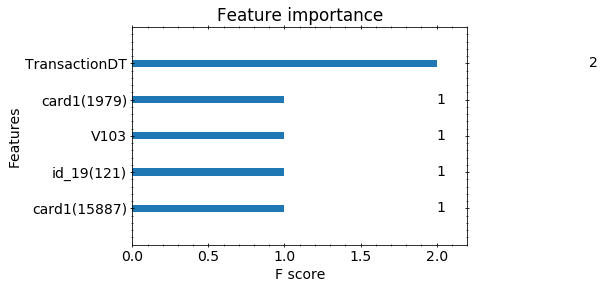

In [56]:
ax = xgboost.plot_importance(model)
ax.grid(which='both', visible=False)
plt.show()